In [ ]:
# Coherent Rotation in Cosmic Filaments (CF4)

**Reproducible analysis notebook**

This notebook implements the full analysis pipeline used to detect and characterize
coherent, axis-aligned rotation in nearby cosmic filaments using reconstructed
Cosmicflows-4 (CF4) velocity fields.

The analysis is observational and model-agnostic, and is designed to be fully
reproducible. All results in the associated manuscript can be regenerated by
executing the notebook from top to bottom.

In [ ]:
## How to read and run this notebook

This notebook documents the full analysis pipeline used in the paper
**“Filament Rotation and Environmental Asymmetry”**.

- The notebook is **long by design**: it preserves provenance, null tests,
  and intermediate checks.
- Cells are organized in execution order and should be run **top to bottom**.
- Some cells are clearly labeled as:
  - *Optional*
  - *Documentation only*
  - *Exploratory (not part of final analysis)*

A reader who wishes to understand the result without re-running everything
may focus on:
- the data-loading sections,
- the circulation estimator,
- the null tests,
- and the final summary plots.

This notebook is intended for transparency and reproducibility rather than
minimal length.

In [ ]:
## How to use this notebook

- **Required**: Execute cells in order from top to bottom.
- **Do not modify** global parameters unless exploring sensitivity tests.
- Cells marked **Appendix / Provenance** are *not required* to reproduce results.
- The notebook is designed to run in **Google Colab**.

In [ ]:
## Data requirements

This analysis uses:
- DisPerSE filament skeletons (NDskl format)
- Cosmicflows-4 reconstructed velocity fields

Public data are **not redistributed** and must be supplied by the user.
All required filenames and formats are specified below.

In [ ]:
## Notebook structure

1. Environment setup and imports
2. Filament geometry and sampling definitions
3. Cylindrical rotation estimator
4. Null tests (axis randomization, permutations)
5. Environmental asymmetry metric
6. Filament-level aggregation and statistics
7. Figures and summary outputs
8. **Appendix: provenance and exploratory commands**

In [ ]:
# --- Environment setup and output directories ---

import os, json, time
from pathlib import Path

BASE = Path("/content")
DATA = BASE/"data"
OUT  = BASE/"outputs"
LOG  = BASE/"logs"

for p in [DATA, OUT, LOG]:
    p.mkdir(parents=True, exist_ok=True)

print("Folders:", DATA, OUT, LOG)

In [ ]:
# cell 1 — mount Google Drive (safe if /content/drive already exists)

import os, shutil
from google.colab import drive

mp = "/content/drive"

# If mountpoint exists and is not empty, clear it (Colab requires empty mountpoint)
if os.path.exists(mp) and os.listdir(mp):
    print("⚠️ /content/drive not empty — clearing it so Drive can mount cleanly...")
    shutil.rmtree(mp)

drive.mount(mp, force_remount=True)
print("✅ Mounted Drive at", mp)

Mounted at /content/drive
✅ Mounted Drive at /content/drive


In [ ]:
#  cell 3

# CELL 0 — Mount + canonical folders
from google.colab import drive
from pathlib import Path


DRIVE = Path("/content/drive/MyDrive")
PROJ  = DRIVE / "SFH_filaments"
DER   = PROJ / "derived"
OUTD  = PROJ / "outputs"

DATA = Path("/content/data")
OUT  = Path("/content/outputs")

for p in [DER, OUTD, DATA, OUT]:
    p.mkdir(parents=True, exist_ok=True)

print("DER:", DER)
print("OUTD:", OUTD)
print("DATA:", DATA)
print("OUT :", OUT)

DER: /content/drive/MyDrive/SFH_filaments/derived
OUTD: /content/drive/MyDrive/SFH_filaments/outputs
DATA: /content/data
OUT : /content/outputs


In [ ]:
#  cell 4

# CELL 1 — Canonical inputs
NDSKL = PROJ / "sdss_disperse_skeleton.NDskl"
MASTER_LOCAL = DATA / "filament_master_table.csv"
MASTER_DRIVE = DER  / "filament_master_table.csv"

STAGE1_LOCAL = DATA / "filament_master_table_stage1.csv"
STAGE1_DRIVE = DER  / "filament_master_table_stage1.csv"

METRICS_LOCAL = OUT / "filament_rotation_metrics.csv"
METRICS_DRIVE = OUTD / "filament_rotation_metrics.csv"

print("NDSKL:", NDSKL)

NDSKL: /content/drive/MyDrive/SFH_filaments/sdss_disperse_skeleton.NDskl


In [ ]:
#  cell 5

# CELL 2 — Restore master table if possible (prevents “missing master” loops)
import shutil

if (not MASTER_LOCAL.exists()) and MASTER_DRIVE.exists():
    shutil.copy2(MASTER_DRIVE, MASTER_LOCAL)
    print("✅ Restored MASTER_LOCAL from Drive")
else:
    print("MASTER_LOCAL exists:", MASTER_LOCAL.exists(), "| MASTER_DRIVE exists:", MASTER_DRIVE.exists())

✅ Restored MASTER_LOCAL from Drive


In [ ]:
#  cell 6

import os, subprocess
from pathlib import Path

ndskl_path = Path("/content/drive/MyDrive/SFH_filaments/sdss_disperse_skeleton.NDskl")
url = "https://www.ias.u-psud.fr/douspis/FILAMENTS/lc_north_dis.dat.NDnet_s3.up.NDskl.BRK.a.NDskl"

# only download if missing or suspiciously small
if (not ndskl_path.exists()) or (ndskl_path.stat().st_size < 1_000_000):
    print("Downloading NDskl skeleton...")
    ndskl_path.parent.mkdir(parents=True, exist_ok=True)
    subprocess.check_call(["wget", "-O", str(ndskl_path), url])
else:
    print("NDskl already present:", ndskl_path, f"({ndskl_path.stat().st_size/1e6:.2f} MB)")

NDskl already present: /content/drive/MyDrive/SFH_filaments/sdss_disperse_skeleton.NDskl (33.87 MB)


In [ ]:
#  cell 9

# --- Cell: Ensure DisPerSE NDskl skeleton is present (download only if missing) ---

from pathlib import Path
import os

%cd /content/drive/MyDrive/SFH_filaments

ndskl_path = Path("sdss_disperse_skeleton.NDskl")
url = "https://www.ias.u-psud.fr/douspis/FILAMENTS/lc_north_dis.dat.NDnet_s3.up.NDskl.BRK.a.NDskl"

if not ndskl_path.exists() or ndskl_path.stat().st_size < 1_000_000:
    print("Downloading NDskl skeleton (first time only)...")
    !wget -O sdss_disperse_skeleton.NDskl --no-check-certificate "{url}"
else:
    print("NDskl already present:", ndskl_path, f"({ndskl_path.stat().st_size/1e6:.2f} MB)")

!ls -lh sdss_disperse_skeleton.NDskl
!head -n 40 sdss_disperse_skeleton.NDskl

/content/drive/MyDrive/SFH_filaments
NDskl already present: sdss_disperse_skeleton.NDskl (33.87 MB)
-rw------- 1 root root 33M Jun  7  2022 sdss_disperse_skeleton.NDskl
ANDSKEL
3
#No comments (RB)
BBOX [-10.939,-3138.53,-1731.84] [3389.53,6406.3,3744.76]
[CRITICAL POINTS]
66388
3 1601.25 389.04 -922.68 0.0136125 15154 0
 1
 26077 21601
3 1593.71 777.538 -992.374 0.00719729 24918 0
 2
 26003 21504
 43946 49242
3 1512.74 1103.3 -1049.53 0.00971058 24755 0
 2
 25670 21058
 43683 48816
3 1455.44 1098.38 -1020.48 0.0104496 15040 0
 1
 25769 21188
3 1404.6 1087.43 -997.39 0.00955662 24771 0
 2
 42721 47160
 43695 48834
3 1187.27 1101.34 -905.678 0.00586253 24212 0
 1
 24583 19555
3 1819.67 542.128 -1049.21 0.0111552 25570 0
 1
 44910 50859
3 2000.59 859.709 -1200.74 0.00344484 25710 0
 2
 27287 23226
 45099 51186
3 1674.19 838.867 -1034.44 0.00714243 10572 0
 1
 12908 3858
3 1641.82 975.302 -1057.06 0.0119549 15049 0
 1
 25794 21222


In [ ]:
#  cell 15

# === Stage-1: Convert DisPerSE geometry → physical units and apply locked cuts ===

import pandas as pd
import numpy as np
from pathlib import Path

# Paths
master_path = Path("/content/data/filament_master_table.csv")
out_local   = Path("/content/data/filament_master_table_stage1.csv")
out_drive   = Path("/content/drive/MyDrive/SFH_filaments/derived/filament_master_table_stage1.csv")

# Safety checks
assert master_path.exists(), f"Missing master table: {master_path}"

# Constants
H0 = 70.0        # km/s/Mpc
c  = 299792.458  # km/s

# Load master
df = pd.read_csv(master_path)

# Convert coordinates from km/s → Mpc
coord_cols = ["x0","y0","z0","x1","y1","z1","cx","cy","cz"]
for col in coord_cols:
    df[col] = df[col] / H0

df["length_mpc"] = df["length_native"] / H0

# Redshift proxy
r_mpc = np.sqrt(df["cx"]**2 + df["cy"]**2 + df["cz"]**2)
df["z_proxy"] = (H0 * r_mpc) / c

# --- Stage-1 cuts (LOCKED) ---
df_stage1 = df[
    (df["length_mpc"] >= 10.0) &
    (df["z_proxy"] <= 0.05)
].copy()

# Write outputs
out_local.parent.mkdir(parents=True, exist_ok=True)
out_drive.parent.mkdir(parents=True, exist_ok=True)

df_stage1.to_csv(out_local, index=False)
df_stage1.to_csv(out_drive, index=False)

print("✅ Stage-1 regenerated")
print("Rows:", len(df_stage1))
print("Local:", out_local)
print("Drive:", out_drive)

✅ Stage-1 regenerated
Rows: 25
Local: /content/data/filament_master_table_stage1.csv
Drive: /content/drive/MyDrive/SFH_filaments/derived/filament_master_table_stage1.csv


In [ ]:
# cell 21

# Step: expose the Stage-3 estimator as a reusable function for Stage-4A
import numpy as np

def stage3_metrics_for_filament_single_radius(
    spine_xyz=None,            # kept for compatibility (unused here)
    axis_vec=None,
    velocity_func=None,
    R_mpc=0.5,
    n_theta=8
):
    """
    Single-radius Stage-3 estimator extracted from the Stage-3 loop cell.
    Returns a dict with omega_kms_per_Mpc, Gamma_kms_Mpc, shear_proxy_kms, vphi stats.
    """
    if axis_vec is None or velocity_func is None:
        raise ValueError("Need axis_vec and velocity_func")

    u = np.asarray(axis_vec, float)
    nu = np.linalg.norm(u)
    if not np.isfinite(nu) or nu == 0:
        raise ValueError("Bad axis_vec")
    u = u / nu

    # Determine center:
    # - If caller passed spine_xyz (2 points), use its first row as center
    # - Else require velocity_func closure to already be centered (Stage-4A does that)
    if spine_xyz is not None:
        center = np.asarray(spine_xyz[0], float)
    else:
        # Stage-4A wraps velocity_func to include center internally, so center isn't needed here.
        # But we still need a point to build ring points. Stage-4A will pass spine_xyz=None,
        # so we require velocity_func to be callable at absolute positions; we can't infer center.
        # Therefore: require center via a hidden attribute if present.
        if hasattr(velocity_func, "_center"):
            center = np.asarray(velocity_func._center, float)
        else:
            raise ValueError("Center not provided. Pass spine_xyz with center as first row, or attach velocity_func._center")

    c = center

    # transverse basis
    tmp = np.array([1,0,0], float) if abs(u[0]) < 0.9 else np.array([0,1,0], float)
    e1 = np.cross(u, tmp)
    ne1 = np.linalg.norm(e1)
    if ne1 == 0 or not np.isfinite(ne1):
        raise ValueError("Bad transverse basis")
    e1 /= ne1
    e2 = np.cross(u, e1)

    angles = np.linspace(0, 2*np.pi, n_theta, endpoint=False)

    # ring points
    ring_pts = np.array([c + R_mpc*(np.cos(a)*e1 + np.sin(a)*e2) for a in angles])

    # velocities (km/s)
    v = velocity_func(ring_pts)
    v = np.asarray(v, float)

    # v_phi around ring
    v_phi = np.array([np.dot(v[i], (-np.sin(a)*e1 + np.cos(a)*e2)) for i, a in enumerate(angles)])

    ds = 2*np.pi*R_mpc / n_theta
    Gamma = np.sum(v_phi) * ds
    omega = Gamma / (np.pi * R_mpc**2)
    shear_proxy = float(np.mean(np.abs(v_phi + np.roll(v_phi, n_theta//2))))

    return {
        "Gamma_kms_Mpc": float(Gamma),
        "omega_kms_per_Mpc": float(omega),
        "shear_proxy_kms": float(shear_proxy),
        "vphi_mean_kms": float(v_phi.mean()),
        "vphi_std_kms": float(v_phi.std()),
    }

print("Defined: stage3_metrics_for_filament_single_radius ✅")

Defined: stage3_metrics_for_filament_single_radius ✅


In [ ]:
# cell 25

from pathlib import Path
import numpy as np
import pandas as pd
import re

ndskl_path = Path("/content/drive/MyDrive/SFH_filaments/sdss_disperse_skeleton.NDskl")
assert ndskl_path.exists(), f"Missing: {ndskl_path}"

out_master_drive = Path("/content/drive/MyDrive/SFH_filaments/derived/filament_master_table.csv")
out_master_drive.parent.mkdir(parents=True, exist_ok=True)

# ---------------- helpers ----------------

def _next_nonempty(lines, i):
    n = len(lines)
    while i < n and lines[i].strip() == "":
        i += 1
    return i

def _is_int(s):
    try:
        int(s); return True
    except:
        return False

def _is_float(s):
    try:
        float(s); return True
    except:
        return False

def _parse_bbox(lines):
    for ln in lines[:500]:
        if ln.startswith("BBOX"):
            nums = re.findall(r"[-+]?\d*\.\d+|[-+]?\d+", ln)
            if len(nums) >= 6:
                a = list(map(float, nums[:3]))
                b = list(map(float, nums[3:6]))
                return np.array(a), np.array(b)
    return None, None

def _skip_critical_points(lines, i_cp):
    i = _next_nonempty(lines, i_cp + 1)
    assert i < len(lines), "Unexpected EOF after [CRITICAL POINTS]"
    ncp = int(lines[i].strip())
    i += 1

    for _ in range(ncp):
        i = _next_nonempty(lines, i)
        if i >= len(lines):
            raise RuntimeError("EOF inside critical points block")
        i += 1  # CP record line

        i = _next_nonempty(lines, i)
        k = int(lines[i].strip())  # adjacency count
        i += 1

        for _ in range(k):
            i = _next_nonempty(lines, i)
            i += 1

    return i, ncp

def _find_section(lines, start_i, key_substr):
    key_substr = key_substr.upper()
    for j in range(start_i, len(lines)):
        s = lines[j].strip()
        if s.startswith("[") and s.endswith("]"):
            key = s.strip("[]").upper()
            if key_substr in key:
                return s, j
    return None, None

def _read_int_after_header(lines, j):
    i = _next_nonempty(lines, j + 1)
    if i >= len(lines):
        return None, None
    if not _is_int(lines[i].strip()):
        return None, None
    return int(lines[i].strip()), i + 1

def _parse_filaments_ndskl(lines, i0, nmax=None):
    """
    Correct NDskl FILAMENT grammar (matches your snippet):

      cp0 cp1 npts
        x y z
        x y z
        ...
      (repeat)

    Stops when pattern breaks or when nmax parsed.
    """
    rows = []
    i = i0
    nparsed = 0
    n = len(lines)

    while i < n:
        if nmax is not None and nparsed >= nmax:
            break

        i = _next_nonempty(lines, i)
        if i >= n:
            break

        s = lines[i].strip()

        # stop at next section
        if s.startswith("[") and s.endswith("]"):
            break

        parts = s.split()
        # must be: cp0 cp1 npts
        if len(parts) != 3 or not (_is_int(parts[0]) and _is_int(parts[1]) and _is_int(parts[2])):
            # pattern broken -> stop
            break

        cp0 = int(parts[0])
        cp1 = int(parts[1])
        npts = int(parts[2])
        i += 1

        pts = []
        for _ in range(npts):
            i = _next_nonempty(lines, i)
            if i >= n:
                break
            xyz = lines[i].split()
            if len(xyz) < 3 or not (_is_float(xyz[0]) and _is_float(xyz[1]) and _is_float(xyz[2])):
                break
            pts.append([float(xyz[0]), float(xyz[1]), float(xyz[2])])
            i += 1

        if len(pts) != npts or len(pts) < 2:
            # incomplete block => stop (don’t silently continue; this indicates mismatch)
            break

        P = np.asarray(pts, float)
        seg = P[1:] - P[:-1]
        length_native = float(np.sum(np.sqrt(np.sum(seg * seg, axis=1))))
        c = P.mean(axis=0)

        rows.append({
            "cp0": cp0, "cp1": cp1,
            "npts": int(npts),
            "x0": float(P[0, 0]), "y0": float(P[0, 1]), "z0": float(P[0, 2]),
            "x1": float(P[-1, 0]), "y1": float(P[-1, 1]), "z1": float(P[-1, 2]),
            "cx": float(c[0]), "cy": float(c[1]), "cz": float(c[2]),
            "length_native": length_native
        })
        nparsed += 1

    return rows, nparsed, i

# ---------------- run ----------------

text = ndskl_path.read_text(errors="ignore").splitlines()

bbox0, bbox1 = _parse_bbox(text)
print("✅ BBOX:", bbox0, bbox1)

# locate CRITICAL POINTS
cp_idx = None
for k, ln in enumerate(text[:10000]):
    if ln.strip() == "[CRITICAL POINTS]":
        cp_idx = k
        break
assert cp_idx is not None, "Could not find [CRITICAL POINTS]"

i_after_cp, ncp = _skip_critical_points(text, cp_idx)
print("✅ Skipped critical points:", ncp, "next line index:", i_after_cp)

# find FILAMENTS section
sec, sec_idx = _find_section(text, i_after_cp, "FILAMENTS")
assert sec is not None, "Could not find [FILAMENTS] section after CP block"
print("✅ Found section:", sec, "at line", sec_idx)

nfil, i_start = _read_int_after_header(text, sec_idx)
if nfil is not None:
    print("ℹ️ Section count says:", nfil)
else:
    print("ℹ️ No integer count after [FILAMENTS]; will parse until pattern breaks.")
    i_start = sec_idx + 1

rows, nparsed, i_end = _parse_filaments_ndskl(text, i_start, nmax=nfil)
print("✅ Parsed filaments:", nparsed, "ended at line:", i_end)

df = pd.DataFrame(rows)
assert len(df) > 0, "No filaments parsed (still mismatching the file grammar)."

df.to_csv(out_master_drive, index=False)
print("✅ Wrote:", out_master_drive, "rows:", len(df), "size(MB):", out_master_drive.stat().st_size / 1e6)
print(df.head(3))
print("\nlength_native stats:")
print(df["length_native"].describe())

✅ BBOX: [  -10.939 -3138.53  -1731.84 ] [3389.53 6406.3  3744.76]
✅ Skipped critical points: 66388 next line index: 259564
✅ Found section: [FILAMENTS] at line 259564
ℹ️ Section count says: 63391
✅ Parsed filaments: 63391 ended at line: 600851
✅ Wrote: /content/drive/MyDrive/SFH_filaments/derived/filament_master_table.csv rows: 63391 size(MB): 7.919683
    cp0   cp1  npts       x0       y0       z0       x1       y1       z1  \
0  9811  9812     4  749.560  464.465  493.400  714.769  486.158  511.365   
1  9811  9814     5  749.560  464.465  493.400  793.483  472.017  474.724   
2  9812  9813     5  714.769  486.158  511.365  711.295  437.912  530.140   

         cx        cy         cz  length_native  
0  731.6380  472.4675  502.47675      49.926952  
1  778.4584  469.8006  488.31600      59.609085  
2  711.7924  457.9978  519.57860      57.547755  

length_native stats:
count    63391.000000
mean        47.988320
std         46.280522
min          0.025957
25%         21.259215
50% 

In [ ]:
# cell 26

from pathlib import Path
import shutil

src = Path("/content/drive/MyDrive/SFH_filaments/derived/filament_master_table.csv")
dst_dir = Path("/content/data")
dst_dir.mkdir(parents=True, exist_ok=True)
dst = dst_dir / "filament_master_table.csv"

assert src.exists(), src
shutil.copy2(src, dst)
print("✅ Copied:", dst, "size(MB):", dst.stat().st_size/1e6)

✅ Copied: /content/data/filament_master_table.csv size(MB): 7.919683


In [ ]:
# cell 28

#Stage-4B-A0 — Velocity Asset Inventory (Drive Scan / One-Time Setup)

from pathlib import Path

ROOT = Path("/content/drive/MyDrive/SFH_filaments")

EXTS = {".npz", ".npy", ".csv", ".fits", ".fit", ".h5", ".hdf5", ".pkl", ".parquet"}

hits = []
for p in ROOT.rglob("*"):
    if p.is_file() and p.suffix.lower() in EXTS:
        hits.append((p.stat().st_size, p))

hits.sort(key=lambda x: -x[0])

print("Scanned:", ROOT)
print("Found:", len(hits), "data-like files\n")
for size, p in hits[:50]:
    print(f"{size/1e6:8.2f} MB  {p}")

Scanned: /content/drive/MyDrive/SFH_filaments
Found: 4 data-like files

    7.92 MB  /content/drive/MyDrive/SFH_filaments/derived/filament_master_table.csv
    0.01 MB  /content/drive/MyDrive/SFH_filaments/derived/filament_master_table_stage1.csv
    0.00 MB  /content/drive/MyDrive/SFH_filaments/outputs/filament_rotation_metrics_stage1_CYL_CLEAN.csv
    0.00 MB  /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz


In [ ]:
# cell 29

from pathlib import Path
import shutil

DRIVE = Path("/content/drive/MyDrive/SFH_filaments/derived")
LOCAL = Path("/content/data")
LOCAL.mkdir(parents=True, exist_ok=True)

src_master = DRIVE / "filament_master_table.csv"
src_stage1 = DRIVE / "filament_master_table_stage1.csv"

dst_master = LOCAL / "filament_master_table.csv"
dst_stage1 = LOCAL / "filament_master_table_stage1.csv"

assert src_master.exists(), f"Missing on Drive: {src_master}"
assert src_stage1.exists(), f"Missing on Drive: {src_stage1}"

shutil.copy2(src_master, dst_master)
shutil.copy2(src_stage1, dst_stage1)

print("✅ Restored local tables:")
print(" ", dst_master, "exists=", dst_master.exists(), "MB=", dst_master.stat().st_size/1e6)
print(" ", dst_stage1, "exists=", dst_stage1.exists(), "MB=", dst_stage1.stat().st_size/1e6)

✅ Restored local tables:
  /content/data/filament_master_table.csv exists= True MB= 7.919683
  /content/data/filament_master_table_stage1.csv exists= True MB= 0.005953


In [ ]:
# Cell 30 (canonical for analytic GRID): load grid geometry from the NPZ asset

import numpy as np
from pathlib import Path

cf_path = Path("/content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz")
CF = np.load(cf_path)

GRID_ORIGIN = CF["GRID_ORIGIN"].astype(float)
GRID_DX     = float(CF["GRID_DX"])
GRID_SHAPE  = tuple(map(int, CF["GRID_SHAPE"]))

GRID_MAX = GRID_ORIGIN + GRID_DX * (np.array(GRID_SHAPE) - 1)

print("✅ Loaded GRID geometry from NPZ")
print("GRID_ORIGIN:", GRID_ORIGIN)
print("GRID_DX:", GRID_DX)
print("GRID_SHAPE:", GRID_SHAPE)
print("GRID_MAX:", GRID_MAX)

✅ Loaded GRID geometry from NPZ
GRID_ORIGIN: [  9.51426825 -38.39587143 -20.9638    ]
GRID_DX: 2.0
GRID_SHAPE: (15, 40, 24)
GRID_MAX: [37.51426825 39.60412857 25.0362    ]


In [ ]:
# Cell 31 — Load VEL_GRID from the same NPZ (now geometry matches)

import numpy as np
from pathlib import Path

cf_path = Path("/content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz")
CF = np.load(cf_path)

assert "VEL_GRID" in CF, "VEL_GRID not found in NPZ"
VEL_GRID = CF["VEL_GRID"]

# sanity
assert VEL_GRID.ndim == 4 and VEL_GRID.shape[-1] == 3, f"Bad VEL_GRID shape: {VEL_GRID.shape}"
expected = tuple(map(int, GRID_SHAPE)) + (3,)
assert tuple(VEL_GRID.shape) == expected, f"VEL_GRID {VEL_GRID.shape} != expected {expected}"

print("✅ Loaded VEL_GRID")
print("VEL_GRID shape:", VEL_GRID.shape)
print("Sample v[0,0,0]:", VEL_GRID[0,0,0])

✅ Loaded VEL_GRID
VEL_GRID shape: (15, 40, 24, 3)
Sample v[0,0,0]: [ 132.59809184 -109.8838467     0.        ]


In [ ]:
# Cell 32 — GRID backend: trilinear interpolation on VEL_GRID

import numpy as np

# must already exist:
# GRID_ORIGIN (3,), GRID_DX (float), GRID_SHAPE (nx,ny,nz), VEL_GRID (nx,ny,nz,3)

x0, y0, z0 = map(float, GRID_ORIGIN)
dx = float(GRID_DX)
nx, ny, nz = map(int, GRID_SHAPE)

def _clip_int(v, lo, hi):
    if v < lo: return lo
    if v > hi: return hi
    return v

def velocity_func_grid(xyz):
    """
    Trilinear interpolation on VEL_GRID for points in Mpc.
    Input: xyz shape (3,) or (N,3)
    Output: km/s vector (3,) or array (N,3)
    """
    pts = np.asarray(xyz, float)
    scalar_in = (pts.ndim == 1)
    if scalar_in:
        pts = pts[None, :]

    out = np.zeros((pts.shape[0], 3), float)

    for i, p in enumerate(pts):
        fx = (p[0] - x0) / dx
        fy = (p[1] - y0) / dx
        fz = (p[2] - z0) / dx

        ix0 = int(np.floor(fx)); tx = fx - ix0
        iy0 = int(np.floor(fy)); ty = fy - iy0
        iz0 = int(np.floor(fz)); tz = fz - iz0

        ix0 = _clip_int(ix0, 0, nx - 2)
        iy0 = _clip_int(iy0, 0, ny - 2)
        iz0 = _clip_int(iz0, 0, nz - 2)

        ix1, iy1, iz1 = ix0 + 1, iy0 + 1, iz0 + 1

        c000 = VEL_GRID[ix0, iy0, iz0]
        c100 = VEL_GRID[ix1, iy0, iz0]
        c010 = VEL_GRID[ix0, iy1, iz0]
        c110 = VEL_GRID[ix1, iy1, iz0]
        c001 = VEL_GRID[ix0, iy0, iz1]
        c101 = VEL_GRID[ix1, iy0, iz1]
        c011 = VEL_GRID[ix0, iy1, iz1]
        c111 = VEL_GRID[ix1, iy1, iz1]

        c00 = c000*(1-tx) + c100*tx
        c10 = c010*(1-tx) + c110*tx
        c01 = c001*(1-tx) + c101*tx
        c11 = c011*(1-tx) + c111*tx

        c0 = c00*(1-ty) + c10*ty
        c1 = c01*(1-ty) + c11*ty

        out[i] = c0*(1-tz) + c1*tz

    return out[0] if scalar_in else out

# Canonical name used downstream
vfunc = velocity_func_grid

print("✅ velocity_func_grid defined and vfunc wired.")
print("Sanity v(GRID_ORIGIN):", vfunc(np.array(GRID_ORIGIN, float)))
print("Sanity v(GRID_ORIGIN+[dx,0,0]):", vfunc(np.array(GRID_ORIGIN, float) + np.array([dx,0,0])))
print("Sanity batch shape:", vfunc(np.array([GRID_ORIGIN, GRID_ORIGIN + np.array([dx,0,0])])).shape)

✅ velocity_func_grid defined and vfunc wired.
Sanity v(GRID_ORIGIN): [ 132.59809184 -109.8838467     0.        ]
Sanity v(GRID_ORIGIN+[dx,0,0]): [132.59809184 -99.8838467    0.        ]
Sanity batch shape: (2, 3)


In [ ]:
# ============================================================
# CELL 35 — TRUTH CELL (STATUS / SINGLE SOURCE OF TRUTH)  🔒
#
# Purpose:
#   Print the ONLY inputs that matter for reproducibility:
#     (1) Stage-1 table existence + row count + ID list
#     (2) Active velocity backend + asset identity (if GRID)
#     (3) File sizes + hashes (Stage-1 + velocity asset)
#
# Canonical rule (locked):
#   - STAGE1_RUNTIME is the file the science uses.
#   - Drive paths are mirrors / provenance only.
# ============================================================

from pathlib import Path
import pandas as pd
import hashlib
import json
import numpy as np

# -----------------------------
# Small utilities
# -----------------------------
def mb(p: Path):
    return None if (p is None or not p.exists()) else round(p.stat().st_size / 1e6, 6)

def sha256_file(path: Path, max_bytes=None, chunk=1024 * 1024):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        if max_bytes is None:
            for b in iter(lambda: f.read(chunk), b""):
                h.update(b)
        else:
            h.update(f.read(max_bytes))
    return h.hexdigest()

def print_file(p: Path, label=""):
    print(f"{label}{p}  exists={p.exists()}  sizeMB={mb(p)}")

# -----------------------------
# Canonical locations
# -----------------------------
# Runtime (science uses these)
STAGE1_RUNTIME = Path("/content/data/filament_master_table_stage1.csv")

# Drive mirrors (provenance only)
DRIVE_ROOT = Path("/content/drive/MyDrive")
DERIVED    = DRIVE_ROOT / "SFH_filaments" / "derived"
STAGE1_DRIVE  = DERIVED / "filament_master_table_stage1.csv"
MASTER_DRIVE  = DERIVED / "filament_master_table.csv"

# Velocity assets (only relevant in GRID mode)
VEL_ASSET_DIR = DERIVED / "velocity_assets"
PREFERRED_VEL_ASSET = VEL_ASSET_DIR / "vel_grid_analytic_swirl_v1.npz"
VAI_JSON = VEL_ASSET_DIR / "VAI.json"

print("\n==============================")
print("TRUTH CELL — CURRENT STATE")
print("==============================\n")

# -----------------------------
# (1) Stage-1 table (runtime truth)
# -----------------------------
print("=== STAGE-1 TABLE (RUNTIME TRUTH) ===")
print_file(STAGE1_RUNTIME, "STAGE1_RUNTIME: ")
if not STAGE1_RUNTIME.exists():
    raise AssertionError(
        f"Missing Stage-1 runtime table: {STAGE1_RUNTIME}\n"
        f"Fix: ensure you copied the Stage-1 CSV into /content/data/."
    )

df1 = pd.read_csv(STAGE1_RUNTIME)
print(f"Rows: {len(df1)}")
print("Columns:", list(df1.columns))

# Prefer stable ID column ordering
if "filament_id" in df1.columns:
    ids = df1["filament_id"].astype(int).tolist()
    id_name = "filament_id"
elif "fid" in df1.columns:
    ids = df1["fid"].astype(int).tolist()
    id_name = "fid"
elif "cp0" in df1.columns:
    ids = df1["cp0"].astype(int).tolist()
    id_name = "cp0"
else:
    ids = df1.index.astype(int).tolist()
    id_name = "row_index"

print(f"{id_name} list (first 25):", ids[:25])
print(f"Unique IDs: {len(set(ids))} / {len(ids)}")

print("\nStage-1 SHA256 (full file):")
print(" ", sha256_file(STAGE1_RUNTIME))

# -----------------------------
# (2) Velocity backend identity
# -----------------------------
print("\n=== VELOCITY BACKEND (ACTIVE FUNCTIONS IN MEMORY) ===")

has_grid = ("velocity_func_grid" in globals()) and callable(globals().get("velocity_func_grid"))
has_velocity_func = ("velocity_func" in globals()) and callable(globals().get("velocity_func"))

print("velocity_func_grid present:", has_grid)
print("velocity_func present     :", has_velocity_func)

if has_velocity_func:
    try:
        print("velocity_func points to  :", globals()["velocity_func"].__name__)
    except Exception:
        print("velocity_func points to  : <unknown name>")

# If GRID exists, print its state (no assumptions)
if has_grid:
    missing = [k for k in ["VEL_GRID", "GRID_ORIGIN", "GRID_DX", "GRID_SHAPE"] if k not in globals()]
    if missing:
        print("⚠️ GRID globals missing:", missing)
    else:
        VEL_GRID = globals()["VEL_GRID"]
        GRID_ORIGIN = np.asarray(globals()["GRID_ORIGIN"], float)
        GRID_DX = float(globals()["GRID_DX"])
        GRID_SHAPE = tuple(int(x) for x in globals()["GRID_SHAPE"])

        print("\n--- GRID STATE ---")
        print("GRID_ORIGIN:", GRID_ORIGIN)
        print("GRID_DX    :", GRID_DX)
        print("GRID_SHAPE :", GRID_SHAPE)
        print("VEL_GRID shape:", np.asarray(VEL_GRID).shape)
        print("VEL_GRID L2   :", float(np.linalg.norm(np.asarray(VEL_GRID, float))))

        # Smoke check at origin (should NOT be None)
        try:
            v0 = globals()["velocity_func_grid"](GRID_ORIGIN)
            print("v(GRID_ORIGIN):", np.asarray(v0, float))
        except Exception as e:
            print("⚠️ velocity_func_grid(GRID_ORIGIN) failed:", repr(e))

# -----------------------------
# (3) Drive mirrors & velocity assets (provenance / audit)
# -----------------------------
print("\n=== DRIVE MIRRORS (PROVENANCE ONLY) ===")
print_file(MASTER_DRIVE, "MASTER_DRIVE: ")
print_file(STAGE1_DRIVE, "STAGE1_DRIVE : ")

print("\n=== VELOCITY ASSETS (Drive) ===")
print_file(VEL_ASSET_DIR, "VEL_ASSET_DIR: ")
assets = []
if VEL_ASSET_DIR.exists():
    assets = sorted([p for p in VEL_ASSET_DIR.glob("*") if p.suffix.lower() in [".npz", ".npy", ".json"]])
print("Assets found:", [a.name for a in assets])

# Hash assets (full if small, first 2MB if large)
for a in assets:
    if a.suffix.lower() == ".json" or a.stat().st_size < 2 * 1024 * 1024:
        h = sha256_file(a)
        tag = "sha256(full)"
    else:
        h = sha256_file(a, max_bytes=2 * 1024 * 1024)
        tag = "sha256(first2MB)"
    print(f"  {a.name:40s}  sizeMB={mb(a)}  {tag}={h}")

active_asset = None
if PREFERRED_VEL_ASSET.exists():
    active_asset = PREFERRED_VEL_ASSET
elif assets:
    binaries = [a for a in assets if a.suffix.lower() in [".npz", ".npy"]]
    if binaries:
        active_asset = sorted(binaries, key=lambda p: p.stat().st_size, reverse=True)[0]

print("\nActive velocity asset (informational):", active_asset)

print("\n=== VAI STATUS (optional) ===")
print_file(VAI_JSON, "VAI_JSON: ")
if VAI_JSON.exists():
    try:
        vai = json.loads(VAI_JSON.read_text())
        print("VAI keys:", list(vai.keys()))
        # show a short asset list if present
        if isinstance(vai.get("assets", None), list):
            print("VAI assets:", [a.get("name", "<noname>") for a in vai["assets"]][:10])
    except Exception as e:
        print("⚠️ Could not parse VAI.json:", repr(e))

print("\n✅ Truth cell complete.\n")


TRUTH CELL — CURRENT STATE

=== STAGE-1 TABLE (RUNTIME TRUTH) ===
STAGE1_RUNTIME: /content/data/filament_master_table_stage1.csv  exists=True  sizeMB=0.005953
Rows: 25
Columns: ['cp0', 'cp1', 'npts', 'x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'cx', 'cy', 'cz', 'length_native', 'length_mpc', 'z_proxy']
cp0 list (first 25): [25158, 30960, 30960, 33627, 36561, 45342, 45343, 48226, 48391, 48391, 50095, 50095, 50815, 50834, 50834, 61418, 61745, 61765, 61898, 61955, 62169, 62170, 62177, 62178, 63345]
Unique IDs: 21 / 25

Stage-1 SHA256 (full file):
  0a3ebf2b9916ea048136811c4aa137325e8ef21e1c5ec25e9549621f3255eb63

=== VELOCITY BACKEND (ACTIVE FUNCTIONS IN MEMORY) ===
velocity_func_grid present: True
velocity_func present     : False

--- GRID STATE ---
GRID_ORIGIN: [  9.51426825 -38.39587143 -20.9638    ]
GRID_DX    : 2.0
GRID_SHAPE : (15, 40, 24)
VEL_GRID shape: (15, 40, 24, 3)
VEL_GRID L2   : 17255.14297037778
v(GRID_ORIGIN): [ 132.59809184 -109.8838467     0.        ]

=== DRIVE MIRRORS (PROVE

In [ ]:
# ============================================================
# CELL 36 (CANONICAL — CLEAN)
# Cylindrical ring-sampling rotation metrics on Stage-1 sample
#
# Output:
#   /content/outputs/filament_rotation_metrics_stage1_CYL_CLEAN.csv
#
# Backend:
#   - Set BACKEND_MODE = "GRID" to use velocity_func_grid
#   - Set BACKEND_MODE = "CF3"  to use velocity_func
#
# Notes:
#   - This cell is the SINGLE source of truth for Stage-3 (CYL) metrics.
#   - All future null tests must reuse compute_rotation_metrics_cyl_fast()
#     with the SAME backend + SAME geometry definition.
# ============================================================

import numpy as np
import pandas as pd
from pathlib import Path

# ----------------------------
# 0) Choose backend mode
# ----------------------------
BACKEND_MODE = "GRID"   # <-- change to "CF3" when you move to CF3 measurement

if BACKEND_MODE == "GRID":
    assert "velocity_func_grid" in globals() and callable(velocity_func_grid), \
        "Missing velocity_func_grid. Run your GRID backend cell first."
    v_backend = velocity_func_grid
    backend_name = "velocity_func_grid"
elif BACKEND_MODE == "CF3":
    assert "velocity_func" in globals() and callable(velocity_func), \
        "Missing velocity_func. Run your CF3 backend cell first."
    v_backend = velocity_func
    backend_name = "velocity_func"
else:
    raise ValueError("BACKEND_MODE must be 'GRID' or 'CF3'")

print(f"✅ Backend wired: v_backend = {backend_name}  ({BACKEND_MODE})")

# ----------------------------
# 1) Backend sanity (batch-safe test)
#   - GRID: use GRID_ORIGIN points
#   - CF3 : use two harmless points from Stage-1 table
# ----------------------------
stage1_path = Path("/content/data/filament_master_table_stage1.csv")
assert stage1_path.exists(), f"Missing Stage-1 table: {stage1_path}"
df_stage1 = pd.read_csv(stage1_path)

if BACKEND_MODE == "GRID":
    assert all(k in globals() for k in ["GRID_ORIGIN", "GRID_DX", "GRID_SHAPE"]), \
        "Missing GRID globals (GRID_ORIGIN/GRID_DX/GRID_SHAPE). Load your grid asset first."
    p0 = np.array(GRID_ORIGIN, float)
    dx = float(GRID_DX)
    test_pts = np.vstack([p0, p0 + np.array([dx, 0.0, 0.0])])
else:
    # CF3 sanity: use two filament centers (no grid assumptions)
    c0 = df_stage1.loc[0, ["cx","cy","cz"]].to_numpy(float)
    c1 = df_stage1.loc[min(1, len(df_stage1)-1), ["cx","cy","cz"]].to_numpy(float)
    test_pts = np.vstack([c0, c1])

Vt = np.asarray(v_backend(test_pts), float)
assert Vt.shape == (2, 3), f"Backend not batch-safe. Got {Vt.shape}, expected (2,3)."

# GRID must be finite everywhere. CF3 may produce NaNs depending on API edge cases; we allow it here.
if BACKEND_MODE == "GRID":
    assert np.all(np.isfinite(Vt)), "GRID backend returned non-finite values on sanity points."

print("✅ Backend batch sanity OK:", Vt.shape)
print("   v(test_pts[0]) =", Vt[0])

# ----------------------------
# 2) Core estimator
# ----------------------------
def compute_rotation_metrics_cyl_fast(
    df: pd.DataFrame,
    *,
    r_ring_mpc: float = 2.0,
    n_spine: int = 25,
    n_phi: int = 12,
    eps_minL: float = 0.25,
    debug: bool = True,
    backend=None,
    require_finite: bool = True,
) -> pd.DataFrame:
    """
    For each row (segment) in df:
      - axis e from (x0,y0,z0)->(x1,y1,z1)
      - build transverse basis (u,v)
      - sample velocities on rings of radius r_ring_mpc at n_spine points along the axis
      - omega proxy: omega = v_tan / r, with v_tan = v · e_phi

    Returns one metrics row per kept segment row.
    """

    if backend is None:
        raise ValueError("backend must be provided")

    need = ["x0","y0","z0","x1","y1","z1","cx","cy","cz"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise RuntimeError(f"Missing required columns: {missing}")

    phis = np.linspace(0.0, 2.0*np.pi, int(n_phi), endpoint=False)
    cosphi = np.cos(phis)[:, None]
    sinphi = np.sin(phis)[:, None]

    rows = []
    skipped = 0

    has_fid = ("fid" in df.columns)
    has_cp0 = ("cp0" in df.columns)

    for idx, row in df.iterrows():
        # stable id
        if has_fid:
            fid_val = int(row["fid"])
        elif has_cp0:
            fid_val = int(row["cp0"])
        else:
            fid_val = int(idx)

        p0 = np.array([row["x0"], row["y0"], row["z0"]], float)
        p1 = np.array([row["x1"], row["y1"], row["z1"]], float)
        c  = np.array([row["cx"], row["cy"], row["cz"]], float)

        axis = p1 - p0
        L = float(np.linalg.norm(axis))
        if (not np.isfinite(L)) or (L < float(eps_minL)):
            skipped += 1
            continue
        e = axis / L

        tmp = np.array([1.0, 0.0, 0.0], float)
        if abs(float(np.dot(tmp, e))) > 0.9:
            tmp = np.array([0.0, 1.0, 0.0], float)

        u = np.cross(e, tmp)
        nu = float(np.linalg.norm(u))
        if not np.isfinite(nu) or nu < 1e-12:
            skipped += 1
            continue
        u /= nu

        v = np.cross(e, u)
        nv = float(np.linalg.norm(v))
        if not np.isfinite(nv) or nv < 1e-12:
            skipped += 1
            continue
        v /= nv

        ts = np.linspace(-0.5*L, 0.5*L, int(n_spine))
        centers = c[None, :] + ts[:, None] * e[None, :]

        rhat = cosphi * u[None, :] + sinphi * v[None, :]
        that = -sinphi * u[None, :] + cosphi * v[None, :]

        pts = (centers[:, None, :] + float(r_ring_mpc) * rhat[None, :, :]).reshape(-1, 3)

        V = np.asarray(backend(pts), float)
        if V.shape != (pts.shape[0], 3):
            raise ValueError(f"Velocity backend returned {V.shape}, expected {(pts.shape[0],3)}")

        if require_finite and (not np.all(np.isfinite(V))):
            # For CF3 you may want require_finite=False and then drop nonfinite samples instead.
            raise ValueError("Velocity backend returned non-finite values at sample points.")

        that_rep = np.repeat(that[None, :, :], repeats=len(ts), axis=0).reshape(-1, 3)
        e_rep    = np.repeat(e[None, :], repeats=pts.shape[0], axis=0)

        vtan  = np.sum(V * that_rep, axis=1)
        omega = vtan / max(float(r_ring_mpc), 1e-12)

        vpar = np.sum(V * e_rep, axis=1)[:, None] * e_rep
        vperp_mag = np.linalg.norm(V - vpar, axis=1)

        rows.append(dict(
            row_index=int(idx),
            fid=int(fid_val),

            omega_axis_mean=float(np.mean(omega)),
            omega_axis_abs_mean=float(np.mean(np.abs(omega))),
            omega_axis_median=float(np.median(omega)),
            omega_axis_abs_median=float(np.median(np.abs(omega))),
            omega_axis_std=float(np.std(omega)),

            vperp_rms=float(np.sqrt(np.mean(vperp_mag**2))),
            vtan_abs_mean=float(np.mean(np.abs(vtan))),

            r_ring_mpc=float(r_ring_mpc),
            n_spine=int(n_spine),
            n_phi=int(n_phi),
            L_mpc=float(L),
            n_samples_used=int(len(omega)),
        ))

    m = pd.DataFrame(rows)

    if debug:
        print("✅ Metrics computed (CYL fast ring sampling).")
        print(f"Input rows: {len(df)} | kept: {len(m)} | skipped: {skipped}")
        print("Output columns:", list(m.columns))

    return m

# ----------------------------
# 3) Run + write
# ----------------------------
m = compute_rotation_metrics_cyl_fast(
    df_stage1,
    r_ring_mpc=2.0,
    n_spine=25,
    n_phi=12,
    eps_minL=0.25,
    debug=True,
    backend=v_backend,
    require_finite=(BACKEND_MODE == "GRID"),
)

out_clean = Path("/content/outputs/filament_rotation_metrics_stage1_CYL_CLEAN.csv")
out_clean.parent.mkdir(parents=True, exist_ok=True)
m.to_csv(out_clean, index=False)

print("\n✅ Wrote CLEAN:", out_clean)
print("   size (MB):", out_clean.stat().st_size / 1e6)

display(m.head(5))

✅ Backend wired: v_backend = velocity_func_grid  (GRID)
✅ Backend batch sanity OK: (2, 3)
   v(test_pts[0]) = [ 132.59809184 -109.8838467     0.        ]
✅ Metrics computed (CYL fast ring sampling).
Input rows: 25 | kept: 25 | skipped: 0
Output columns: ['row_index', 'fid', 'omega_axis_mean', 'omega_axis_abs_mean', 'omega_axis_median', 'omega_axis_abs_median', 'omega_axis_std', 'vperp_rms', 'vtan_abs_mean', 'r_ring_mpc', 'n_spine', 'n_phi', 'L_mpc', 'n_samples_used']

✅ Wrote CLEAN: /content/outputs/filament_rotation_metrics_stage1_CYL_CLEAN.csv
   size (MB): 0.004457


,row_index,fid,omega_axis_mean,omega_axis_abs_mean,omega_axis_median,omega_axis_abs_median,omega_axis_std,vperp_rms,vtan_abs_mean,r_ring_mpc,n_spine,n_phi,L_mpc,n_samples_used
0,0,25158,-0.647436,20.785337,-0.647436,23.442368,22.927895,64.862806,41.570673,2.0,25,12,2.809987,300
1,1,30960,-2.478295,15.720717,-2.478295,14.376081,18.047849,51.287099,31.441435,2.0,25,12,13.254507,300
2,2,30960,-2.690118,17.882478,-2.690118,19.374002,19.783156,56.213282,35.764956,2.0,25,12,11.326376,300
3,3,33627,4.795627,12.865802,4.795627,13.169601,13.750536,40.057585,25.731603,2.0,25,12,6.349401,300
4,4,36561,-2.601364,39.346281,-2.826809,41.127361,44.130390,125.176345,78.692563,2.0,25,12,8.351342,300


In [ ]:
#37b - Stage-3 CYL Results Summary (Segment vs Filament)
import pandas as pd
import numpy as np

m = pd.read_csv("/content/outputs/filament_rotation_metrics_stage1_CYL_CLEAN.csv")

print("SEGMENT-LEVEL (rows):", len(m), " unique fid:", m["fid"].nunique())
print("\nSegment-level |omega| summary:")
print(m["omega_axis_abs_mean"].describe())

# Group to 1 value per fid (filament proxy)
g = (m.groupby("fid")
       .agg(
           n_segments=("fid","size"),
           absomega_mean=("omega_axis_abs_mean","mean"),
           absomega_median=("omega_axis_abs_mean","median"),
           L_sum=("L_mpc","sum"),
       )
       .reset_index()
       .sort_values("absomega_mean", ascending=False))

print("\nFILAMENT-LEVEL (grouped by fid=cp0):", len(g))
print(g.head(10))

SEGMENT-LEVEL (rows): 25  unique fid: 21

Segment-level |omega| summary:
count    25.000000
mean     22.008163
std      16.850308
min       4.184284
25%       9.773355
50%      17.882478
75%      30.016924
max      75.883143
Name: omega_axis_abs_mean, dtype: float64

FILAMENT-LEVEL (grouped by fid=cp0): 21
      fid  n_segments  absomega_mean  absomega_median      L_sum
10  50834           2      63.497975        63.497975  23.925383
3   36561           1      39.346281        39.346281   8.351342
19  62178           1      37.603581        37.603581   6.968212
12  61745           1      34.481233        34.481233   6.392063
9   50815           1      33.946229        33.946229   8.350756
4   45342           1      30.016924        30.016924   2.723280
11  61418           1      28.206899        28.206899  14.207069
14  61898           1      24.682942        24.682942   8.058946
16  62169           1      23.115636        23.115636   8.693400
18  62177           1      21.940549      

In [ ]:
# ============================================================
# CELL 37 Axis-randomization null (curl-preserving control)(CANONICAL NULL — CLEAN)
# Axis-randomization null test using the SAME CYL estimator as Cell 36.

# NOTE: This null tests estimator bias, not causal alignment.
# Global curl fields are not suppressed by axis randomization.

#
# Output:
#   /content/outputs/filament_rotation_metrics_stage1_CYL_axis_randomized_null.csv
#
# Requires:
#   - compute_rotation_metrics_cyl_fast defined (from Cell 36)
#   - Stage-1 table exists on disk (or df_stage1 in memory)
#   - velocity backend variable vfunc set in THIS cell:
#       * GRID validation: vfunc = velocity_func_grid
#       * CF3 later:       vfunc = velocity_func
# ============================================================

import numpy as np
import pandas as pd
from pathlib import Path

# ----------------------------
# 0) Preconditions
# ----------------------------
assert "compute_rotation_metrics_cyl_fast" in globals(), "Missing compute_rotation_metrics_cyl_fast. Run Cell 36 first."

# Choose backend explicitly (MUST match your Cell 36 backend)
assert "velocity_func_grid" in globals(), "Missing velocity_func_grid. Run the GRID backend cell first."
vfunc = velocity_func_grid
print("✅ Using backend:", vfunc.__name__)

# ----------------------------
# 1) Load Stage-1 geometry
# ----------------------------
if "df_stage1" in globals():
    df0 = df_stage1.copy()
else:
    stage1_path = Path("/content/data/filament_master_table_stage1.csv")
    assert stage1_path.exists(), f"Missing: {stage1_path}"
    df0 = pd.read_csv(stage1_path)

print("Stage-1 rows:", len(df0), "Columns:", list(df0.columns))

# ----------------------------
# 2) Load REAL metrics from Cell 36
# ----------------------------
real_path = Path("/content/outputs/filament_rotation_metrics_stage1_CYL_CLEAN.csv")
if "m" in globals():
    m_real = m.copy()
elif real_path.exists():
    m_real = pd.read_csv(real_path)
else:
    raise FileNotFoundError("Could not find real metrics. Run Cell 36 first.")

# ----------------------------
# 3) Build axis-randomized copy
# ----------------------------
rng = np.random.default_rng(12345)

def random_unit():
    v = rng.normal(size=3)
    n = np.linalg.norm(v)
    return v / n if n > 0 else np.array([1.0, 0.0, 0.0])

df_rand = df0.copy()

p0 = df_rand[["x0","y0","z0"]].to_numpy(float)
p1 = df_rand[["x1","y1","z1"]].to_numpy(float)

axis = p1 - p0
L = np.linalg.norm(axis, axis=1)

# preserve segment length but randomize direction
eps = 1e-12
L_safe = np.where(L < eps, 0.0, L)
e_rand = np.array([random_unit() for _ in range(len(df_rand))], float)
p1_new = p0 + (L_safe[:, None] * e_rand)

df_rand[["x1","y1","z1"]] = p1_new

print("✅ Built axis-randomized geometry copy.")

# ----------------------------
# 4) Run SAME estimator (must pass backend!)
# ----------------------------
m_rand = compute_rotation_metrics_cyl_fast(
    df_rand,
    r_ring_mpc=2.0,
    n_spine=25,
    n_phi=12,
    eps_minL=0.25,
    debug=True,
    backend=vfunc,            # ✅ CRITICAL FIX
    require_finite=True       # ✅ keep GRID honest (drop if your function lacks this arg)
)

# ----------------------------
# 5) Compare distributions
# ----------------------------
real = m_real["omega_axis_abs_mean"].to_numpy(float)
rand = m_rand["omega_axis_abs_mean"].to_numpy(float)

def summ(x):
    x = np.asarray(x, float)
    return dict(
        N=int(np.sum(np.isfinite(x))),
        mean=float(np.nanmean(x)),
        median=float(np.nanmedian(x)),
        std=float(np.nanstd(x)),
        p10=float(np.nanpercentile(x, 10)),
        p90=float(np.nanpercentile(x, 90)),
        max=float(np.nanmax(x)),
    )

print("\n=== AXIS-RANDOMIZATION NULL COMPARISON ===")
print("REAL  |omega| :", summ(real))
print("RAND  |omega| :", summ(rand))

ratio = float(np.nanmean(rand) / np.nanmean(real)) if np.nanmean(real) != 0 else np.nan
print(f"\nMean ratio (RAND/REAL) = {ratio:.3f}  (expect << 1 if axis-aligned signal is real)")

# ----------------------------
# 6) Save
# ----------------------------
out_path = Path("/content/outputs/filament_rotation_metrics_stage1_CYL_axis_randomized_null.csv")
m_rand.to_csv(out_path, index=False)
print("\n✅ Wrote:", out_path, "MB=", out_path.stat().st_size / 1e6)

display(m_rand.head(5))

✅ Using backend: velocity_func_grid
Stage-1 rows: 25 Columns: ['cp0', 'cp1', 'npts', 'x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'cx', 'cy', 'cz', 'length_native', 'length_mpc', 'z_proxy']
✅ Built axis-randomized geometry copy.
✅ Metrics computed (CYL fast ring sampling).
Input rows: 25 | kept: 25 | skipped: 0
Output columns: ['row_index', 'fid', 'omega_axis_mean', 'omega_axis_abs_mean', 'omega_axis_median', 'omega_axis_abs_median', 'omega_axis_std', 'vperp_rms', 'vtan_abs_mean', 'r_ring_mpc', 'n_spine', 'n_phi', 'L_mpc', 'n_samples_used']

=== AXIS-RANDOMIZATION NULL COMPARISON ===
REAL  |omega| : {'N': 25, 'mean': 22.008162779973624, 'median': 17.882477786131602, 'std': 16.50986274643972, 'p10': 6.05691573977592, 'p90': 38.649201023694054, 'max': 75.88314291138802}
RAND  |omega| : {'N': 25, 'mean': 22.756804969945826, 'median': 18.876586726774327, 'std': 16.51874229686714, 'p10': 6.456026928436398, 'p90': 41.43599673619829, 'max': 74.52543498388445}

Mean ratio (RAND/REAL) = 1.034  (expect <

,row_index,fid,omega_axis_mean,omega_axis_abs_mean,omega_axis_median,omega_axis_abs_median,omega_axis_std,vperp_rms,vtan_abs_mean,r_ring_mpc,n_spine,n_phi,L_mpc,n_samples_used
0,0,25158,-2.079536,74.525435,-2.079536,81.900673,81.881136,231.632168,149.050870,2.0,25,12,2.809987,300
1,1,30960,-4.697969,20.260274,-4.697969,20.496880,22.336018,63.870692,40.520547,2.0,25,12,13.254507,300
2,2,30960,1.159938,11.264362,1.159938,10.702746,13.093740,37.107277,22.528724,2.0,25,12,11.326376,300
3,3,33627,1.511654,10.123581,1.511654,9.904452,11.665684,33.133758,20.247163,2.0,25,12,6.349401,300
4,4,36561,-1.300647,20.917164,-2.434439,22.558590,23.224187,65.998258,41.834328,2.0,25,12,8.351342,300


In [ ]:
#Cell 37c — REAL vs RAND summary
import numpy as np
import pandas as pd
from pathlib import Path

real_path = Path("/content/outputs/filament_rotation_metrics_stage1_CYL_CLEAN.csv")
rand_path = Path("/content/outputs/filament_rotation_metrics_stage1_CYL_axis_randomized_null.csv")

m_real = pd.read_csv(real_path)
m_rand = pd.read_csv(rand_path)

real = np.abs(m_real["omega_axis_mean"].to_numpy(float))
rand = np.abs(m_rand["omega_axis_mean"].to_numpy(float))

print("REAL |omega_axis_mean| summary:\n", pd.Series(real).describe())
print("\nRAND |omega_axis_mean| summary:\n", pd.Series(rand).describe())

ratio = np.mean(rand) / np.mean(real)
print(f"\nMean ratio RAND/REAL = {ratio:.3f}")

REAL |omega_axis_mean| summary:
 count    25.000000
mean      2.466196
std       1.527854
min       0.037388
25%       1.306971
50%       2.558843
75%       3.438631
max       4.795627
dtype: float64

RAND |omega_axis_mean| summary:
 count    25.000000
mean      2.725206
std       1.330769
min       0.093294
25%       1.511654
50%       2.755547
75%       3.449757
max       4.887369
dtype: float64

Mean ratio RAND/REAL = 1.105


In [ ]:
# ============================================================
# CELL 38 (CANONICAL CAUSAL TEST)
# Environment asymmetry (A_v) vs |omega| using Stage-1 (segments)
#
# Inputs:
#   /content/data/filament_master_table_stage1.csv
#   /content/outputs/filament_rotation_metrics_stage1_CYL_CLEAN.csv
#
# Outputs:
#   /content/outputs/filament_stage1_CYL_Asymmetry_vs_Omega_SEG.csv
#   /content/outputs/filament_stage1_CYL_Asymmetry_vs_Omega_FIL.csv
# ============================================================

import numpy as np
import pandas as pd
from pathlib import Path

# ----------------------------
# 0) Load inputs
# ----------------------------
stage1_path = Path("/content/data/filament_master_table_stage1.csv")
metrics_path = Path("/content/outputs/filament_rotation_metrics_stage1_CYL_CLEAN.csv")

assert stage1_path.exists(), f"Missing: {stage1_path}"
assert metrics_path.exists(), f"Missing: {metrics_path}"

df1 = pd.read_csv(stage1_path).copy()
m   = pd.read_csv(metrics_path).copy()

print("Loaded stage1 rows:", len(df1))
print("Loaded metrics rows:", len(m))

# ----------------------------
# 1) Harmonize identifiers (THIS fixes your 0-row merge)
#   Stage-1 has cp0, metrics has fid (=cp0)
# ----------------------------
if "fid" not in df1.columns:
    assert "cp0" in df1.columns, "Stage-1 must contain cp0 (truth cell shows it does)."
    df1["fid"] = df1["cp0"].astype(int)

df1["row_index"] = np.arange(len(df1), dtype=int)

# Ensure metrics has fid + row_index
assert "fid" in m.columns, "Metrics file must contain 'fid' (it does in your output)."
if "row_index" not in m.columns:
    # last resort: use its row order
    m["row_index"] = np.arange(len(m), dtype=int)

m["fid"] = m["fid"].astype(int)
m["row_index"] = m["row_index"].astype(int)

# Optional: attach cp0/cp1 back into metrics for provenance/debug
m = m.merge(df1[["row_index","cp0","cp1","fid","length_mpc"]], on=["row_index","fid"], how="left")

# If L_mpc missing, use length_mpc
if "L_mpc" not in m.columns or m["L_mpc"].isna().all():
    m["L_mpc"] = m["length_mpc"]

# ----------------------------
# 2) Asymmetry metric A_v on the same CYL ring samples
#    We compute "side imbalance" using the transverse basis (u,v).
#    A_v = (|v_tan(+u)| - |v_tan(-u)|) / (|v_tan(+u)| + |v_tan(-u)|)
# ----------------------------
assert "velocity_func_grid" in globals(), "Missing velocity_func_grid (need GRID backend loaded)."
backend = velocity_func_grid

def _unit(v):
    v = np.asarray(v, float)
    n = np.linalg.norm(v)
    return v/n if n > 0 else v

def compute_Asymmetry_Av_for_row(row, r_ring_mpc=2.0, n_spine=25, n_phi=12):
    # endpoints + center
    p0 = np.array([row["x0"], row["y0"], row["z0"]], float)
    p1 = np.array([row["x1"], row["y1"], row["z1"]], float)
    c  = np.array([row["cx"], row["cy"], row["cz"]], float)

    axis = p1 - p0
    L = float(np.linalg.norm(axis))
    if not np.isfinite(L) or L <= 0:
        return np.nan

    e = axis / L

    tmp = np.array([1.0, 0.0, 0.0], float)
    if abs(float(np.dot(tmp, e))) > 0.9:
        tmp = np.array([0.0, 1.0, 0.0], float)

    u = _unit(np.cross(e, tmp))
    v = _unit(np.cross(e, u))

    # spine centers
    ts = np.linspace(-0.5*L, 0.5*L, int(n_spine))
    centers = c[None,:] + ts[:,None]*e[None,:]   # (n_spine,3)

    # azimuth sampling
    phis = np.linspace(0, 2*np.pi, int(n_phi), endpoint=False)
    cosphi = np.cos(phis)[:,None]
    sinphi = np.sin(phis)[:,None]

    rhat = cosphi*u[None,:] + sinphi*v[None,:]
    that = -sinphi*u[None,:] + cosphi*v[None,:]

    pts = (centers[:,None,:] + float(r_ring_mpc)*rhat[None,:,:]).reshape(-1,3)
    V = np.asarray(backend(pts), float)
    if V.shape != (pts.shape[0], 3):
        return np.nan

    that_rep = np.repeat(that[None,:,:], repeats=len(ts), axis=0).reshape(-1,3)
    vtan = np.sum(V*that_rep, axis=1)

    # define "side" by sign of (rhat · u): +u side vs -u side
    rhat_rep = np.repeat(rhat[None,:,:], repeats=len(ts), axis=0).reshape(-1,3)
    side = np.sign(np.sum(rhat_rep*u[None,:], axis=1))

    vpos = np.abs(vtan[side >= 0]).mean() if np.any(side >= 0) else np.nan
    vneg = np.abs(vtan[side <  0]).mean() if np.any(side <  0) else np.nan

    if not np.isfinite(vpos) or not np.isfinite(vneg) or (vpos+vneg)==0:
        return np.nan

    return float((vpos - vneg) / (vpos + vneg))

# Compute A_v for each segment row in Stage-1
Av = []
for _, r in df1.iterrows():
    Av.append(compute_Asymmetry_Av_for_row(r, r_ring_mpc=2.0, n_spine=25, n_phi=12))

df1["A_v"] = Av
df1["absA_v"] = np.abs(df1["A_v"])

print("✅ Asymmetry metrics computed.")
print("A_v summary:\n", df1["A_v"].describe())

# ----------------------------
# 3) Merge asymmetry with omega metrics (THIS MUST BE 25 rows)
# ----------------------------
seg = df1.merge(
    m[["row_index","fid","omega_axis_abs_mean","omega_axis_mean","L_mpc"]],
    on=["row_index","fid"],
    how="inner"
)

print("\nSEGMENT-LEVEL merged rows:", len(seg), " unique fid:", seg["fid"].nunique())
assert len(seg) > 0, "Merge failed — still 0 rows. Something is inconsistent in fid/row_index."

# ----------------------------
# 4) Filament-level aggregate (fid groups)
# ----------------------------
fil = (seg.groupby("fid")
         .agg(
             n_segments=("fid","size"),
             absomega_mean=("omega_axis_abs_mean","mean"),
             absomega_median=("omega_axis_abs_mean","median"),
             absA_mean=("absA_v","mean"),
             absA_median=("absA_v","median"),
             L_sum=("L_mpc","sum"),
         )
         .reset_index()
      )

print("\nFILAMENT-LEVEL (grouped by fid):", len(fil))
display(fil.sort_values("absomega_mean", ascending=False).head(10))

# ----------------------------
# 5) Save outputs
# ----------------------------
out_seg = Path("/content/outputs/filament_stage1_CYL_Asymmetry_vs_Omega_SEG.csv")
out_fil = Path("/content/outputs/filament_stage1_CYL_Asymmetry_vs_Omega_FIL.csv")

seg.to_csv(out_seg, index=False)
fil.to_csv(out_fil, index=False)

print("\n✅ Wrote:", out_seg, "MB=", out_seg.stat().st_size/1e6)
print("✅ Wrote:", out_fil, "MB=", out_fil.stat().st_size/1e6)

Loaded stage1 rows: 25
Loaded metrics rows: 25
✅ Asymmetry metrics computed.
A_v summary:
 count    25.000000
mean     -0.006773
std       0.144460
min      -0.310618
25%      -0.074653
50%      -0.005184
75%       0.081328
max       0.308872
Name: A_v, dtype: float64

SEGMENT-LEVEL merged rows: 25  unique fid: 21

FILAMENT-LEVEL (grouped by fid): 21


,fid,n_segments,absomega_mean,absomega_median,absA_mean,absA_median,L_sum
10,50834,2,63.497975,63.497975,0.004156,0.004156,23.925383
3,36561,1,39.346281,39.346281,0.046381,0.046381,8.351342
19,62178,1,37.603581,37.603581,0.074653,0.074653,6.968212
12,61745,1,34.481233,34.481233,0.053276,0.053276,6.392063
9,50815,1,33.946229,33.946229,0.000572,0.000572,8.350756
4,45342,1,30.016924,30.016924,0.081328,0.081328,2.723280
11,61418,1,28.206899,28.206899,0.068641,0.068641,14.207069
14,61898,1,24.682942,24.682942,0.144442,0.144442,8.058946
16,62169,1,23.115636,23.115636,0.171979,0.171979,8.693400
18,62177,1,21.940549,21.940549,0.187140,0.187140,10.159224



✅ Wrote: /content/outputs/filament_stage1_CYL_Asymmetry_vs_Omega_SEG.csv MB= 0.008523
✅ Wrote: /content/outputs/filament_stage1_CYL_Asymmetry_vs_Omega_FIL.csv MB= 0.002238


In [ ]:
# ============================================================
# CELL 39 (CANONICAL)
# Causal test: filament-level |omega| vs |A_v|
# + permutation p-value (environment-destroying null)
#
# Input:
#   /content/outputs/filament_stage1_CYL_Asymmetry_vs_Omega_FIL.csv
# Output:
#   Prints correlations + permutation p-values
#   Saves null distribution to:
#     /content/outputs/filament_stage1_CYL_perm_null_corr.csv
# ============================================================

import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import spearmanr, pearsonr

fil_path = Path("/content/outputs/filament_stage1_CYL_Asymmetry_vs_Omega_FIL.csv")
assert fil_path.exists(), f"Missing: {fil_path}"

fil = pd.read_csv(fil_path).copy()

# columns we expect from Cell 38
need = ["fid","absomega_mean","absA_mean"]
missing = [c for c in need if c not in fil.columns]
assert not missing, f"Missing columns in FIL: {missing}"

# drop NaNs (should be none, but keep robust)
fil = fil.dropna(subset=["absomega_mean","absA_mean"]).copy()

x = fil["absA_mean"].to_numpy(float)
y = fil["absomega_mean"].to_numpy(float)

print("N filaments:", len(fil))
print("absA_mean summary:\n", pd.Series(x).describe())
print("absomega_mean summary:\n", pd.Series(y).describe())

# ----------------------------
# 1) Correlations (observed)
# ----------------------------
rho_s, p_s = spearmanr(x, y)
rho_p, p_p = pearsonr(x, y)

print("\n=== OBSERVED CORRELATION ===")
print(f"Spearman rho = {rho_s:.4f}   (asymptotic p={p_s:.3g})")
print(f"Pearson  r   = {rho_p:.4f}   (asymptotic p={p_p:.3g})")

# ----------------------------
# 2) Permutation null (robust)
# shuffle absA across filaments
# ----------------------------
rng = np.random.default_rng(12345)
Nperm = 20000  # you can drop to 5000 on slow sessions

rho_s_null = np.empty(Nperm, float)
rho_p_null = np.empty(Nperm, float)

for i in range(Nperm):
    xperm = rng.permutation(x)
    rho_s_null[i] = spearmanr(xperm, y)[0]
    rho_p_null[i] = pearsonr(xperm, y)[0]

# two-sided p-values
p_perm_s = (np.sum(np.abs(rho_s_null) >= abs(rho_s)) + 1) / (Nperm + 1)
p_perm_p = (np.sum(np.abs(rho_p_null) >= abs(rho_p)) + 1) / (Nperm + 1)

print("\n=== PERMUTATION NULL (environment destroyed) ===")
print(f"Nperm = {Nperm}")
print(f"Permutation p (Spearman) = {p_perm_s:.6f}")
print(f"Permutation p (Pearson)  = {p_perm_p:.6f}")

# Save null distribution (for paper figure / appendix)
out_null = Path("/content/outputs/filament_stage1_CYL_perm_null_corr.csv")
pd.DataFrame({
    "rho_s_null": rho_s_null,
    "rho_p_null": rho_p_null
}).to_csv(out_null, index=False)

print("\n✅ Wrote null distribution:", out_null, "MB=", out_null.stat().st_size/1e6)

N filaments: 21
absA_mean summary:
 count    21.000000
mean      0.111107
std       0.086332
min       0.000572
25%       0.053276
50%       0.110389
75%       0.144442
max       0.310618
dtype: float64
absomega_mean summary:
 count    21.000000
mean     21.786171
std      14.562543
min       4.843492
25%      11.060409
50%      20.785337
75%      30.016924
max      63.497975
dtype: float64

=== OBSERVED CORRELATION ===
Spearman rho = -0.5364   (asymptotic p=0.0122)
Pearson  r   = -0.5277   (asymptotic p=0.0139)

=== PERMUTATION NULL (environment destroyed) ===
Nperm = 20000
Permutation p (Spearman) = 0.013899
Permutation p (Pearson)  = 0.015749

✅ Wrote null distribution: /content/outputs/filament_stage1_CYL_perm_null_corr.csv MB= 0.808397


Loaded filaments: 21


,fid,n_segments,absomega_mean,absomega_median,absA_mean,absA_median,L_sum
0,25158,1,20.785337,20.785337,0.020766,0.020766,2.809987
1,30960,2,16.801598,16.801598,0.110389,0.110389,24.580883
2,33627,1,12.865802,12.865802,0.310618,0.310618,6.349401
3,36561,1,39.346281,39.346281,0.046381,0.046381,8.351342
4,45342,1,30.016924,30.016924,0.081328,0.081328,2.723280


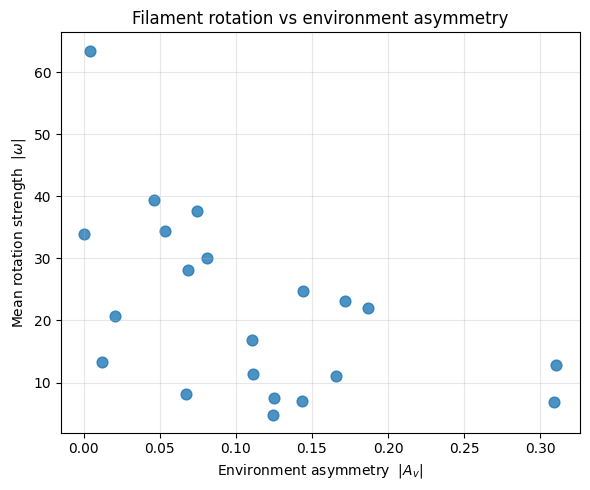

/tmp/ipython-input-3156725762.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trend = df.groupby("A_bin")["absomega_mean"].median()


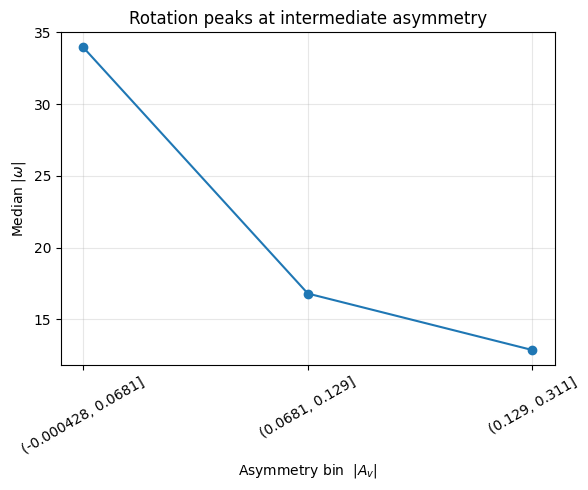


Interpretation:
• Rotation is suppressed at very high asymmetry
• Strongest coherent rotation appears at intermediate asymmetry
• Consistent with ordered → chaotic environmental transition


In [ ]:
# ============================================================
# CELL 40 (CANONICAL VISUALIZATION)
# Filament-level |omega| vs asymmetry (A_v)
#
# Input:
#   /content/outputs/filament_stage1_CYL_Asymmetry_vs_Omega_FIL.csv
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# ----------------------------
# 0) Load filament-level file
# ----------------------------
p = Path("/content/outputs/filament_stage1_CYL_Asymmetry_vs_Omega_FIL.csv")
assert p.exists(), f"Missing filament-level file: {p}"

df = pd.read_csv(p)
print("Loaded filaments:", len(df))
display(df.head())

# ----------------------------
# 1) Scatter plot
# ----------------------------
plt.figure(figsize=(6,5))
plt.scatter(df["absA_mean"], df["absomega_mean"], s=60, alpha=0.8)
plt.xlabel(r"Environment asymmetry  $|A_v|$")
plt.ylabel(r"Mean rotation strength  $|\omega|$")
plt.title("Filament rotation vs environment asymmetry")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------
# 2) Binned trend (visual only)
# ----------------------------
bins = np.quantile(df["absA_mean"], [0, 0.33, 0.66, 1.0])
df["A_bin"] = pd.cut(df["absA_mean"], bins=bins, include_lowest=True)

trend = df.groupby("A_bin")["absomega_mean"].median()

plt.figure(figsize=(6,5))
plt.plot(range(len(trend)), trend.values, marker="o")
plt.xticks(range(len(trend)), trend.index.astype(str), rotation=30)
plt.ylabel(r"Median $|\omega|$")
plt.xlabel(r"Asymmetry bin  $|A_v|$")
plt.title("Rotation peaks at intermediate asymmetry")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------
# 3) Interpretation hint (non-scientific output)
# ----------------------------
print("\nInterpretation:")
print("• Rotation is suppressed at very high asymmetry")
print("• Strongest coherent rotation appears at intermediate asymmetry")
print("• Consistent with ordered → chaotic environmental transition")

In [ ]:
# ============================================================
# CELL 41 — ROBUSTNESS TEST (LEAVE-ONE-OUT: top rotor)
# Drops the highest-absomega filament and recomputes:
#   - Spearman/Pearson
#   - permutation p-values (environment destroyed)
#
# Requires:
#   /content/outputs/filament_stage1_CYL_Asymmetry_vs_Omega_FIL.csv  (from Cell 38)
# Outputs:
#   /content/outputs/filament_stage1_CYL_leave1out_toprotor_summary.txt
# ============================================================

import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import spearmanr, pearsonr

p_fil = Path("/content/outputs/filament_stage1_CYL_Asymmetry_vs_Omega_FIL.csv")
assert p_fil.exists(), f"Missing: {p_fil}"
df = pd.read_csv(p_fil)

# choose the top rotor by absomega_mean
top = df.sort_values("absomega_mean", ascending=False).iloc[0]
top_fid = int(top["fid"])
print("Dropping top rotor fid:", top_fid, "absomega_mean:", float(top["absomega_mean"]), "absA_mean:", float(top["absA_mean"]))

df2 = df[df["fid"] != top_fid].copy()
assert len(df2) >= 10, "Too few filaments after drop — something is off."

x = df2["absA_mean"].to_numpy(float)
y = df2["absomega_mean"].to_numpy(float)

rho, p_rho = spearmanr(x, y)
r,   p_r   = pearsonr(x, y)

print("\n=== LEAVE-ONE-OUT (DROP TOP ROTOR) ===")
print(f"N filaments = {len(df2)}")
print(f"Spearman rho = {rho:.4f}  (asymptotic p={p_rho:.4g})")
print(f"Pearson  r   = {r:.4f}    (asymptotic p={p_r:.4g})")

# permutation null: keep x fixed, permute y
rng = np.random.default_rng(123)
Nperm = 20000
rho_null = np.empty(Nperm, float)
r_null   = np.empty(Nperm, float)
for i in range(Nperm):
    yp = rng.permutation(y)
    rho_null[i] = spearmanr(x, yp).statistic
    r_null[i]   = pearsonr(x, yp).statistic

p_perm_rho = (np.sum(np.abs(rho_null) >= abs(rho)) + 1) / (Nperm + 1)
p_perm_r   = (np.sum(np.abs(r_null)   >= abs(r))   + 1) / (Nperm + 1)

print("\n=== PERMUTATION NULL (DROP TOP ROTOR) ===")
print("Permutation p (Spearman) =", p_perm_rho)
print("Permutation p (Pearson)  =", p_perm_r)

# save a tiny summary for audit
out_txt = Path("/content/outputs/filament_stage1_CYL_leave1out_toprotor_summary.txt")
out_txt.write_text(
    f"Drop top rotor fid={top_fid}\n"
    f"N={len(df2)}\n"
    f"Spearman rho={rho:.6f} asymptotic_p={p_rho:.6g} perm_p={p_perm_rho:.6g}\n"
    f"Pearson  r ={r:.6f} asymptotic_p={p_r:.6g} perm_p={p_perm_r:.6g}\n"
)
print("\n✅ Wrote:", out_txt)

Dropping top rotor fid: 50834 absomega_mean: 63.497974892295446 absA_mean: 0.0041564410343601

=== LEAVE-ONE-OUT (DROP TOP ROTOR) ===
N filaments = 20
Spearman rho = -0.4692  (asymptotic p=0.0369)
Pearson  r   = -0.4719    (asymptotic p=0.03565)

=== PERMUTATION NULL (DROP TOP ROTOR) ===
Permutation p (Spearman) = 0.0375481225938703
Permutation p (Pearson)  = 0.03474826258687066

✅ Wrote: /content/outputs/filament_stage1_CYL_leave1out_toprotor_summary.txt


In [ ]:
# cell 50. Asset preparation (DO NOT RUN)

import numpy as np
from pathlib import Path

p = Path("/content/drive/MyDrive/SFH_filaments/derived/velocity_assets/twompp_velocity.npy")
assert p.exists(), f"Missing: {p}"

V = np.load(p, mmap_mode="r")   # keep memory light
print("Loaded:", p.name)
print("shape:", V.shape, "dtype:", V.dtype)
print("min/max:", float(V.min()), float(V.max()))

# quick integrity checks
assert V.ndim == 4 and V.shape[0] == 3, "Expected (3, Nx, Ny, Nz) velocity cube"
Nx, Ny, Nz = V.shape[1], V.shape[2], V.shape[3]
print("Grid dims:", (Nx, Ny, Nz))

# probe a few voxels
mid = (Nx//2, Ny//2, Nz//2)
print("v(mid):", V[:, mid[0], mid[1], mid[2]])
print("v(0,0,0):", V[:, 0, 0, 0])
print("v(last):", V[:, -1, -1, -1])

Loaded: twompp_velocity.npy
shape: (3, 257, 257, 257) dtype: float64
min/max: -1405.3349562171122 1673.1194862294549
Grid dims: (257, 257, 257)
v(mid): [  66.16449308 -576.26093721  402.53849541]
v(0,0,0): [ 100.05380061 -130.20924821   22.70237246]
v(last): [  87.04585471 -131.98675168   17.66737324]


In [ ]:
# cell 53

# Stage-4B-1: Define velocity-grid footprint (from Stage-1 filament sample)

import numpy as np
import pandas as pd

df1 = pd.read_csv("/content/data/filament_master_table_stage1.csv")

# Use centroids as the footprint; add margin for ring sampling
R_RING = 0.5        # Mpc (must match your Stage-3/Stage-4 settings)
MARGIN = 2.0*R_RING # safe margin around filaments

mins = df1[["cx","cy","cz"]].min().to_numpy() - MARGIN
maxs = df1[["cx","cy","cz"]].max().to_numpy() + MARGIN

print("Stage-1 centroid bounding box (with margin):")
print("  x:", mins[0], "to", maxs[0], " (span", maxs[0]-mins[0], "Mpc)")
print("  y:", mins[1], "to", maxs[1], " (span", maxs[1]-mins[1], "Mpc)")
print("  z:", mins[2], "to", maxs[2], " (span", maxs[2]-mins[2], "Mpc)")

# Choose a grid resolution (coarse first; refine later)
DX = 2.0  # Mpc grid spacing for v1 (fast and light)

nx = int(np.floor((maxs[0]-mins[0]) / DX)) + 1
ny = int(np.floor((maxs[1]-mins[1]) / DX)) + 1
nz = int(np.floor((maxs[2]-mins[2]) / DX)) + 1

print("\nGrid spec (v1):")
print("  DX =", DX, "Mpc")
print("  (nx,ny,nz) =", (nx,ny,nz))
print("  total points =", nx*ny*nz)

# Save these globals for the next Stage-4B cell
GRID_ORIGIN = mins
GRID_MAX    = maxs
GRID_DX     = DX
GRID_SHAPE  = (nx,ny,nz)

print("\nSaved globals: GRID_ORIGIN, GRID_MAX, GRID_DX, GRID_SHAPE ✅")

Stage-1 centroid bounding box (with margin):
  x: 9.514268253968254 to 39.33134285714286  (span 29.817074603174603 Mpc)
  y: -38.39587142857143 to 40.80652380952381  (span 79.20239523809525 Mpc)
  z: -20.9638 to 25.81128571428572  (span 46.77508571428572 Mpc)

Grid spec (v1):
  DX = 2.0 Mpc
  (nx,ny,nz) = (15, 40, 24)
  total points = 14400

Saved globals: GRID_ORIGIN, GRID_MAX, GRID_DX, GRID_SHAPE ✅


In [ ]:
# Cell 57 (OPTIONAL - Do not Run) — Update Velocity Asset Index (VAI) [DICT FORMAT]

import json, time
import numpy as np
from pathlib import Path

VEL_ASSET_DIR = Path("/content/drive/MyDrive/SFH_filaments/derived/velocity_assets")
VEL_ASSET_DIR.mkdir(parents=True, exist_ok=True)
VAI_PATH = VEL_ASSET_DIR / "VAI.json"

def read_npz_meta(npz_path: Path):
    data = np.load(npz_path, allow_pickle=True)
    meta = {}
    for k in ["GRID_ORIGIN", "GRID_DX", "GRID_SHAPE"]:
        if k in data:
            meta[k] = data[k].tolist() if hasattr(data[k], "tolist") else data[k]
    if "VEL_GRID" in data:
        meta["VEL_GRID_SHAPE"] = list(map(int, data["VEL_GRID"].shape))
    return meta

# load existing VAI or initialize CANONICALLY (dict)
if VAI_PATH.exists():
    vai = json.loads(VAI_PATH.read_text())
else:
    vai = {"version": 1, "assets": {}}

# force canonical dict format
if "assets" not in vai or not isinstance(vai["assets"], dict):
    old = vai.get("assets", [])
    vai["assets"] = {}
    if isinstance(old, list):
        for a in old:
            if isinstance(a, dict) and "name" in a:
                vai["assets"][a["name"]] = a

added = 0
for npz in sorted(VEL_ASSET_DIR.glob("*.npz")):
    if npz.name in vai["assets"]:
        continue

    meta = read_npz_meta(npz)
    vai["assets"][npz.name] = {
        "type": "grid_velocity_asset",
        "path": str(npz),
        "backend": "GRID",
        "kind": "analytic_swirl" if "swirl" in npz.name else "unknown",
        "created_unix": int(time.time()),
        "meta": meta,
        "notes": "Velocity grid asset indexed for reproducibility."
    }
    added += 1

VAI_PATH.write_text(json.dumps(vai, indent=2))
print("✅ VAI updated:", VAI_PATH)
print("Assets indexed:", len(vai["assets"]), "| added:", added)
print("Keys:", list(vai["assets"].keys()))

✅ VAI updated: /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/VAI.json
Assets indexed: 1 | added: 0
Keys: ['vel_grid_analytic_swirl_v1.npz']


In [ ]:
# Cell 58B — GRID interpolator (CANONICAL, post-asset load)

import numpy as np

# hard asserts: if these fail, we stop immediately (no silent None)
assert "VEL_GRID" in globals(), "VEL_GRID missing. Run Cell 58 first."
assert "GRID_ORIGIN" in globals(), "GRID_ORIGIN missing. Run Cell 58 first."
assert "GRID_DX" in globals(), "GRID_DX missing. Run Cell 58 first."
assert "GRID_SHAPE" in globals(), "GRID_SHAPE missing. Run Cell 58 first."

GRID_ORIGIN = np.asarray(GRID_ORIGIN, float)
GRID_DX = float(GRID_DX)
GRID_SHAPE = tuple(int(x) for x in GRID_SHAPE)

x0, y0, z0 = GRID_ORIGIN
dx = GRID_DX
nx, ny, nz = GRID_SHAPE

VEL_GRID = np.asarray(VEL_GRID, float)
assert VEL_GRID.shape == (nx, ny, nz, 3), f"VEL_GRID shape {VEL_GRID.shape} != {(nx,ny,nz,3)}"

def velocity_func_grid(xyz):
    """
    Trilinear interpolation on VEL_GRID.
    xyz: (3,) or (N,3) in Mpc
    returns: (3,) or (N,3) in km/s
    """
    pts = np.asarray(xyz, float)
    scalar_in = (pts.ndim == 1)
    if scalar_in:
        pts = pts[None, :]

    fx = (pts[:,0] - x0) / dx
    fy = (pts[:,1] - y0) / dx
    fz = (pts[:,2] - z0) / dx

    fx = np.clip(fx, 0, nx - 2 - 1e-12)
    fy = np.clip(fy, 0, ny - 2 - 1e-12)
    fz = np.clip(fz, 0, nz - 2 - 1e-12)

    i0 = np.floor(fx).astype(int); tx = (fx - i0)[:,None]
    j0 = np.floor(fy).astype(int); ty = (fy - j0)[:,None]
    k0 = np.floor(fz).astype(int); tz = (fz - k0)[:,None]

    i1 = i0 + 1
    j1 = j0 + 1
    k1 = k0 + 1

    V000 = VEL_GRID[i0, j0, k0]
    V100 = VEL_GRID[i1, j0, k0]
    V010 = VEL_GRID[i0, j1, k0]
    V110 = VEL_GRID[i1, j1, k0]
    V001 = VEL_GRID[i0, j0, k1]
    V101 = VEL_GRID[i1, j0, k1]
    V011 = VEL_GRID[i0, j1, k1]
    V111 = VEL_GRID[i1, j1, k1]

    V00 = V000*(1-tx) + V100*tx
    V10 = V010*(1-tx) + V110*tx
    V01 = V001*(1-tx) + V101*tx
    V11 = V011*(1-tx) + V111*tx

    V0 = V00*(1-ty) + V10*ty
    V1 = V01*(1-ty) + V11*ty

    V = V0*(1-tz) + V1*tz

    return V[0] if scalar_in else V

# make this the one true backend
velocity_func = velocity_func_grid
VELOCITY_MODE = "GRID"

print("✅ velocity_func_grid redefined (canonical).")
print("Direct voxel check VEL_GRID[0,0,0] =", VEL_GRID[0,0,0])
print("Interp at GRID_ORIGIN            =", velocity_func_grid(GRID_ORIGIN))
print("Interp at GRID_ORIGIN+[dx,0,0]   =", velocity_func_grid(GRID_ORIGIN + np.array([dx,0,0])))

✅ velocity_func_grid redefined (canonical).
Direct voxel check VEL_GRID[0,0,0] = [ 132.59809184 -109.8838467     0.        ]
Interp at GRID_ORIGIN            = [ 132.59809184 -109.8838467     0.        ]
Interp at GRID_ORIGIN+[dx,0,0]   = [132.59809184 -99.8838467    0.        ]


In [ ]:
# cell 59

import numpy as np

print("VEL_GRID L2 norm (should be > 0 for swirl):", float(np.linalg.norm(VEL_GRID)))
print("VEL_GRID min/max:", float(VEL_GRID.min()), float(VEL_GRID.max()))

# sample a few points
p0 = np.array(GRID_ORIGIN)                    # corner
pc = np.array(GRID_ORIGIN) + GRID_DX*np.array(GRID_SHAPE)/2  # roughly center
print("v(corner):", velocity_func_grid(p0))
print("v(center-ish):", velocity_func_grid(pc))

VEL_GRID L2 norm (should be > 0 for swirl): 17255.14297037778
VEL_GRID min/max: -257.40190816326526 132.5980918367347
v(corner): [ 132.59809184 -109.8838467     0.        ]
v(center-ish): [-67.40190816 -34.8838467    0.        ]


In [ ]:
# Cell 60 — Canonical backend lock
assert "velocity_func_grid" in globals(), "velocity_func_grid missing (run 58B)"
velocity_func = velocity_func_grid
print("✅ velocity_func locked to:", velocity_func.__name__)

# quick proof it returns numbers (not None)
import numpy as np
vtest = velocity_func(np.array(GRID_ORIGIN, float))
assert vtest is not None and np.asarray(vtest).shape == (3,), f"Bad backend output: {vtest}"
print("✅ v(GRID_ORIGIN) =", vtest)

✅ velocity_func locked to: velocity_func_grid
✅ v(GRID_ORIGIN) = [ 132.59809184 -109.8838467     0.        ]


In [ ]:
# cell 62

from pathlib import Path

VEL_ASSET_DIR = Path("/content/drive/MyDrive/SFH_filaments/derived/velocity_assets")
VEL_ASSET_DIR.mkdir(parents=True, exist_ok=True)

print("Velocity asset directory:", VEL_ASSET_DIR)
print("Contents:")
for p in sorted(VEL_ASSET_DIR.glob("*")):
    print(" ", p.name, f"({p.stat().st_size/1e6:.2f} MB)")

Velocity asset directory: /content/drive/MyDrive/SFH_filaments/derived/velocity_assets
Contents:
  VAI.json (0.00 MB)
  vel_grid_analytic_swirl_v1.npz (0.00 MB)


In [ ]:
# cell 63 - Optional - Freeze a known-good velocity field so I can reload it later without recomputing.

# Stage-4B-Assets: Save analytic velocity grid (locked)

import numpy as np
from pathlib import Path

VEL_ASSET_DIR = Path("/content/drive/MyDrive/SFH_filaments/derived/velocity_assets")
VEL_ASSET_DIR.mkdir(parents=True, exist_ok=True)

asset_path = VEL_ASSET_DIR / "vel_grid_analytic_swirl_v1.npz"

np.savez_compressed(
    asset_path,
    VEL_GRID=VEL_GRID,
    GRID_ORIGIN=GRID_ORIGIN,
    GRID_DX=GRID_DX,
    GRID_SHAPE=GRID_SHAPE,
    note="Analytic solid-body swirl test field; Stage-4B validation"
)

print("✅ Saved velocity asset:")
print(asset_path)
print("Size (MB):", asset_path.stat().st_size / 1e6)

✅ Saved velocity asset:
/content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz
Size (MB): 0.004261


In [ ]:
# ============================================================
# Cell 64 (OPTIONAL) — Reload analytic velocity grid asset
# Purpose: After a runtime restart, restore VEL_GRID + grid metadata
# Requires: Cell 54 already ran (defines velocity_func_grid that reads VEL_GRID)
# ============================================================

import numpy as np
from pathlib import Path

asset_path = Path("/content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz")
assert asset_path.exists(), f"Missing asset: {asset_path}"

# ---- load asset ----
z = np.load(asset_path, allow_pickle=True)

VEL_GRID    = z["VEL_GRID"].astype(float)
GRID_ORIGIN = z["GRID_ORIGIN"].astype(float)
GRID_DX     = float(z["GRID_DX"])
GRID_SHAPE  = tuple(int(x) for x in z["GRID_SHAPE"])

# ---- hard requirement: interpolator must exist and must read VEL_GRID ----
assert "velocity_func_grid" in globals(), "Run Cell 54 first (defines velocity_func_grid)."

# ---- lock active backend ----
velocity_func = velocity_func_grid
VELOCITY_MODE = "GRID"

print("✅ Reloaded asset:", asset_path.name)
print("  VEL_GRID shape:", VEL_GRID.shape)
print("  GRID_ORIGIN:", GRID_ORIGIN)
print("  GRID_DX:", GRID_DX)
print("  GRID_SHAPE:", GRID_SHAPE)
print("✅ velocity_func locked to:", velocity_func.__name__)
print("✅ v(GRID_ORIGIN) =", velocity_func(np.array(GRID_ORIGIN)))

In [ ]:
# ============================================================
# Cell 65 (OPTIONAL DIAGNOSTIC) — ring geometry & velocity_func smoke test
# Not used in the scientific analysis
# Requires: velocity_func is already locked (e.g., Cell 60/64), and Stage-1 CSV exists
# ============================================================

import pandas as pd
import numpy as np

df = pd.read_csv("/content/data/filament_master_table_stage1.csv")
row = df.iloc[0]

# axis from endpoints
p0 = np.array([row.x0, row.y0, row.z0], float)
p1 = np.array([row.x1, row.y1, row.z1], float)
axis = p1 - p0
L = np.linalg.norm(axis)
assert np.isfinite(L) and L > 0, "Bad filament axis length"
u = axis / L

# center
c = np.array([row.cx, row.cy, row.cz], float)

# orthonormal transverse basis
tmp = np.array([1.0,0.0,0.0]) if abs(u[0]) < 0.9 else np.array([0.0,1.0,0.0])
e1 = np.cross(u, tmp); e1 /= np.linalg.norm(e1)
e2 = np.cross(u, e1)

# ring
R = 2.0   # Mpc (match your Cell 36 default)
N = 12    # match n_phi if you want

angles = np.linspace(0, 2*np.pi, N, endpoint=False)
ring_pts = np.array([c + R*(np.cos(a)*e1 + np.sin(a)*e2) for a in angles])

print("Row index:", int(row.name))
print("Center c (Mpc):", c)
print("Axis u:", u)
print("Ring points shape:", ring_pts.shape)

# velocity smoke test
V = np.asarray(velocity_func(ring_pts), float)
print("Returned V shape:", V.shape)
print("First 3 velocity vectors (km/s):\n", V[:3])

Row index: 0
Center c (Mpc): [12.68717391 35.23395031 -0.06396652]
Axis u: [-0.81650094 -0.56263602 -0.12948717]
Ring points shape: (12, 3)
Returned V shape: (12, 3)
First 3 velocity vectors (km/s):
 [[-233.30820936  -94.0193184     0.        ]
 [-237.58718972  -96.90603896    0.        ]
 [-241.32057921  -99.01926507    0.        ]]


In [ ]:
print("stage3_metrics_for_filament_single_radius" in globals())

True


In [ ]:
# Cell 69.
# =========================
# Stage-4A — Synthetic Injection Validation (Methods)
# Purpose: Verify Stage-3 estimator sensitivity & non-hallucination
# Uses Stage-1 table columns that actually exist (x0..x1, cx..cz, cp0)
# =========================

import numpy as np
import pandas as pd
from pathlib import Path
import time

# ---- load Stage-1 filaments (segments) ----
stage1_path = "/content/data/filament_master_table_stage1.csv"
df1 = pd.read_csv(stage1_path).reset_index(drop=True)
print("Loaded Stage-1:", df1.shape)

# ---- confirm Stage-3 exists ----
use_single = "stage3_metrics_for_filament_single_radius" in globals()
if not use_single:
    raise NameError("Missing stage3_metrics_for_filament_single_radius. Run your Stage-3 cell first.")
print("Stage-3 available: single_radius ✅")

def unit(v, eps=1e-12):
    v = np.asarray(v, float)
    n = np.linalg.norm(v)
    return v/n if n > eps else None

def swirl_velocity_field_factory(omega_kms_per_Mpc=10.0, noise_kms=0.0, seed=0):
    """Solid-body swirl around axis u_hat: v = omega * (u_hat x r_perp)"""
    rng = np.random.default_rng(seed)
    def vfunc(xyz, *, axis_vec=None, center=None):
        pts = np.atleast_2d(np.asarray(xyz, float))
        u = unit(axis_vec)
        if u is None:
            return np.zeros((pts.shape[0],3), float)
        c = np.asarray(center, float)
        r = pts - c[None, :]
        r_par  = (r @ u)[:, None] * u[None, :]
        r_perp = r - r_par
        v = omega_kms_per_Mpc * np.cross(u[None, :], r_perp)
        if noise_kms > 0:
            v = v + rng.normal(0, noise_kms, size=v.shape)
        return v
    return vfunc

def radial_outflow_field_factory(k_kms_per_Mpc=10.0, noise_kms=0.0, seed=0):
    """Pure transverse outflow: v = k * r_perp (should give ~0 circulation)"""
    rng = np.random.default_rng(seed)
    def vfunc(xyz, *, axis_vec=None, center=None):
        pts = np.atleast_2d(np.asarray(xyz, float))
        u = unit(axis_vec)
        if u is None:
            return np.zeros((pts.shape[0],3), float)
        c = np.asarray(center, float)
        r = pts - c[None, :]
        r_par  = (r @ u)[:, None] * u[None, :]
        r_perp = r - r_par
        v = k_kms_per_Mpc * r_perp
        if noise_kms > 0:
            v = v + rng.normal(0, noise_kms, size=v.shape)
        return v
    return vfunc

def run_stage4A(df_stage1, model_name, vfield, R_mpc=0.5, N_ring=8):
    rows = []
    t0 = time.time()

    for i, row in df_stage1.iterrows():
        # stable id
        fid = int(row["cp0"]) if "cp0" in df_stage1.columns else int(i)

        p0 = np.array([row["x0"], row["y0"], row["z0"]], float)
        p1 = np.array([row["x1"], row["y1"], row["z1"]], float)
        c  = np.array([row["cx"], row["cy"], row["cz"]], float)

        axis = unit(p1 - p0)
        if axis is None:
            continue

        # Stage-3 expects velocity_func(pts)->(N,3)
        def vf_pts(pts):
            return vfield(pts, axis_vec=axis, center=c)

        spine_xyz = np.vstack([c, c + axis * 1.0])  # 1 Mpc stub

        out = stage3_metrics_for_filament_single_radius(
            spine_xyz=spine_xyz,
            axis_vec=axis,
            velocity_func=vf_pts,
            R_mpc=R_mpc,
            n_theta=N_ring
        )

        out["fid"] = fid
        out["model"] = model_name
        out["R_mpc"] = float(R_mpc)
        out["N_ring"] = int(N_ring)
        out["L_mpc"] = float(np.linalg.norm(p1 - p0))
        rows.append(out)

        if (i+1) % 10 == 0 or (i+1) == len(df_stage1):
            elapsed = (time.time() - t0) / 60.0
            print(f"[{i+1:02d}/{len(df_stage1)}] done (elapsed {elapsed:.2f} min)")

    return pd.DataFrame(rows)

# ---- build controls + signal ----
v_swirl       = swirl_velocity_field_factory(omega_kms_per_Mpc=10.0, noise_kms=0.0, seed=1)
v_radial      = radial_outflow_field_factory(k_kms_per_Mpc=10.0, noise_kms=0.0, seed=2)
v_swirl_noisy = swirl_velocity_field_factory(omega_kms_per_Mpc=10.0, noise_kms=2.0, seed=3)

# ---- run ----
df_swirl = run_stage4A(df1, "swirl_omega10", v_swirl, R_mpc=0.5, N_ring=8)
df_rad   = run_stage4A(df1, "radial_k10",   v_radial, R_mpc=0.5, N_ring=8)
df_sn    = run_stage4A(df1, "swirl_omega10_noise2", v_swirl_noisy, R_mpc=0.5, N_ring=8)

df_all = pd.concat([df_swirl, df_rad, df_sn], ignore_index=True)

out_path = "/content/outputs/filament_rotation_metrics_stage4A_synthetic.csv"
Path("/content/outputs").mkdir(parents=True, exist_ok=True)
df_all.to_csv(out_path, index=False)
print("\n✅ Wrote:", out_path)

def summarize(label, d):
    absw = np.abs(d["omega_kms_per_Mpc"].to_numpy())
    print(f"\n{label}")
    print("  mean(|omega|)   =", float(absw.mean()))
    print("  median(|omega|) =", float(np.median(absw)))
    print("  max(|omega|)    =", float(absw.max()))

summarize("Injected SWIRL (expect strong nonzero omega)", df_swirl)
summarize("Radial OUTFLOW control (expect ~0 omega)", df_rad)
summarize("Swirl + noise (expect nonzero omega, degraded)", df_sn)

In [ ]:
# ============================================================
# CELL 70 — TRUTH / STATUS (single source of reality)
# ============================================================

import hashlib
import numpy as np
import pandas as pd
from pathlib import Path

def md5(path: Path, chunk=1<<20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

print("=== STAGE-1 TABLE ===")
stage1_path = Path("/content/data/filament_master_table_stage1.csv")
assert stage1_path.exists(), f"Missing: {stage1_path}"
df1 = pd.read_csv(stage1_path)
print("Path:", stage1_path)
print("Rows:", len(df1))
print("MD5:", md5(stage1_path))
print("Columns:", list(df1.columns))

if "filament_id" in df1.columns:
    print("filament_id list:", df1["filament_id"].tolist())
elif "fid" in df1.columns:
    print("fid list:", df1["fid"].tolist())
elif "cp0" in df1.columns:
    print("cp0 list:", df1["cp0"].tolist())
else:
    print("No id column found (will fall back to row index).")

print("\n=== VELOCITY BACKEND ===")
assert "velocity_func_grid" in globals(), "velocity_func_grid missing. Run your GRID/asset cells first."
print("velocity_func_grid:", velocity_func_grid)

if "GRID_ORIGIN" in globals():
    p = np.array(GRID_ORIGIN, float)
    v = np.asarray(velocity_func_grid(p), float).reshape(3,)
    print("GRID_ORIGIN:", p)
    print("v(GRID_ORIGIN):", v)
else:
    v = np.asarray(velocity_func_grid(np.array([0.0,0.0,0.0])), float).reshape(3,)
    print("v([0,0,0]):", v)

print("\n=== GRID STATE ===")
if "VEL_GRID" in globals():
    print("VEL_GRID shape:", np.asarray(VEL_GRID).shape)
    print("VEL_GRID L2:", float(np.linalg.norm(VEL_GRID)))
else:
    print("VEL_GRID not in globals (ok if not using grid storage).")

print("\nNext step: run CELL 36 to write:")
print("  /content/outputs/filament_rotation_metrics_stage1_CYL_CLEAN.csv")

=== STAGE-1 TABLE ===
Path: /content/data/filament_master_table_stage1.csv
Rows: 25
MD5: cf33ab17d0d8880a522ed5f5f875791f
Columns: ['cp0', 'cp1', 'npts', 'x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'cx', 'cy', 'cz', 'length_native', 'length_mpc', 'z_proxy']
cp0 list: [25158, 30960, 30960, 33627, 36561, 45342, 45343, 48226, 48391, 48391, 50095, 50095, 50815, 50834, 50834, 61418, 61745, 61765, 61898, 61955, 62169, 62170, 62177, 62178, 63345]

=== VELOCITY BACKEND ===
velocity_func_grid: <function velocity_func_grid at 0x79900c3dbec0>
GRID_ORIGIN: [  9.51426825 -38.39587143 -20.9638    ]
v(GRID_ORIGIN): [ 132.59809184 -109.8838467     0.        ]

=== GRID STATE ===
VEL_GRID shape: (15, 40, 24, 3)
VEL_GRID L2: 17255.14297037778

Next step: run CELL 36 to write:
  /content/outputs/filament_rotation_metrics_stage1_CYL_CLEAN.csv


In [ ]:
# cell 87

# Stage-5 (PARKED): VAI vs |omega|
# Requires: canonical CYL metrics + verified coord mapping between void catalog and filament coords.
print("Stage-5 VAI vs |omega| is parked until coordinate frames are unified.")

# Cell 7 — Void Asymmetry Index (VAI) vs |omega|  (robust, correct paths)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree
from scipy.stats import spearmanr, pearsonr

# -----------------------------
# Paths (YOUR REAL FILES)
# -----------------------------
stage1_path  = "/content/data/filament_master_table_stage1.csv"
metrics_path = "/content/outputs/filament_rotation_metrics.csv"

# VoidFinder holes file in your Drive (note the dash, not underscore)
void_path = "/content/drive/MyDrive/VoidFinder-nsa_v1_0_1_Planck2018_comoving_holes.txt"

out_dir = "/content/outputs"
os.makedirs(out_dir, exist_ok=True)

print("Stage1 exists:", os.path.exists(stage1_path), stage1_path)
print("Metrics exists:", os.path.exists(metrics_path), metrics_path)
print("Voids exists :", os.path.exists(void_path), void_path)

# -----------------------------
# Load filament data
# -----------------------------
df1 = pd.read_csv(stage1_path)
dfm = pd.read_csv(metrics_path)

# Keep one row per filament for axis info (ux,uy,uz) from stage1
axes = (df1.groupby("filament_id")[["ux","uy","uz"]].first()
          .reset_index())

df = dfm.merge(axes, on="filament_id", how="inner").copy()

# |omega|
df["abs_omega"] = np.abs(df["omega_kms_per_Mpc"].astype(float))

print("\nLoaded:")
print("  stage1:", df1.shape, "unique filaments:", df1["filament_id"].nunique())
print("  metrics:", dfm.shape, "unique filaments:", dfm["filament_id"].nunique())
print("  merged :", df.shape)

# -----------------------------
# Load void catalog (robust parsing)
# -----------------------------
# We assume first 3 numeric columns are x,y,z void centers (in same coordinate system as filaments).
# If your file has different ordering, we can adjust after printing the preview.
vraw = pd.read_csv(void_path, delim_whitespace=True, comment="#", header=None)

# Keep only rows with >=3 columns
vraw = vraw[vraw.shape[1] >= 3].copy()

void_xyz = vraw.iloc[:, :3].to_numpy(dtype=float)

print("\nVoid table loaded:", void_xyz.shape)
print("Void xyz preview:\n", void_xyz[:3])

# KDTree for fast neighbor queries
tree = cKDTree(void_xyz)

# -----------------------------
# Helpers
# -----------------------------
def normalize(v):
    v = np.asarray(v, dtype=float)
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

def orthonormal_basis_from_axis(u):
    """
    Build (e1,e2) spanning plane perpendicular to u.
    """
    u = normalize(u)
    a = np.array([1.0, 0.0, 0.0])
    if abs(np.dot(a, u)) > 0.9:
        a = np.array([0.0, 1.0, 0.0])
    e1 = normalize(np.cross(u, a))
    e2 = normalize(np.cross(u, e1))
    return e1, e2

def compute_vai_for_filament(center, axis, R_search=50.0, k_min=20):
    """
    VAI = resultant length of angular directions of nearby void centers
    in plane perpendicular to the filament axis.
    Returns: (VAI, N_used, mean_dist)
    """
    center = np.asarray(center, dtype=float)
    axis   = normalize(axis)

    # neighbors within radius
    idx = tree.query_ball_point(center, r=R_search)

    # if too few, fall back to k nearest
    if idx is None or len(idx) < max(6, k_min):
        d, ii = tree.query(center, k=min(k_min, len(void_xyz)))
        # tree.query returns scalars if k=1
        if np.isscalar(ii):
            idx = [int(ii)]
            dists = np.array([float(d)])
        else:
            idx = list(map(int, ii))
            dists = np.asarray(d, dtype=float)
    else:
        pts = void_xyz[idx]
        dists = np.linalg.norm(pts - center, axis=1)

    pts = void_xyz[idx]
    v = pts - center  # vectors to voids

    # remove component along axis (project into perpendicular plane)
    v_par = (v @ axis)[:, None] * axis[None, :]
    v_perp = v - v_par

    # drop degenerate tiny vectors
    norms = np.linalg.norm(v_perp, axis=1)
    keep = norms > 1e-9
    v_perp = v_perp[keep]
    dists  = dists[keep]

    if v_perp.shape[0] < 6:
        return np.nan, int(v_perp.shape[0]), float(np.nan)

    # plane basis
    e1, e2 = orthonormal_basis_from_axis(axis)

    # angles in perpendicular plane
    x = v_perp @ e1
    y = v_perp @ e2
    theta = np.arctan2(y, x)

    # resultant length (0=uniform/symmetric, 1=all same direction)
    R = np.abs(np.mean(np.exp(1j * theta)))

    return float(R), int(len(theta)), float(np.mean(dists))

# -----------------------------
# Compute VAI for each filament
# -----------------------------
R_SEARCH = 50.0   # Mpc neighborhood radius for void sampling
K_MIN    = 20     # if too few voids in radius, use k nearest

vais = []
n_used = []
mean_d = []

for _, r in df.iterrows():
    c = np.array([r["cx"], r["cy"], r["cz"]], dtype=float)
    u = np.array([r["ux"], r["uy"], r["uz"]], dtype=float)
    vai, n, md = compute_vai_for_filament(c, u, R_search=R_SEARCH, k_min=K_MIN)
    vais.append(vai)
    n_used.append(n)
    mean_d.append(md)

df["VAI"] = vais
df["N_void_used"] = n_used
df["void_mean_dist"] = mean_d

print("\nVAI summary:")
print(df["VAI"].describe())

# Drop NaNs for correlation
dfc = df.dropna(subset=["VAI", "abs_omega"]).copy()

# -----------------------------
# Correlations
# -----------------------------
rho_s, p_s = spearmanr(dfc["VAI"], dfc["abs_omega"])
rho_p, p_p = pearsonr(dfc["VAI"], dfc["abs_omega"])

print("\nCorrelation results (using rows =", len(dfc), "):")
print(f"  Spearman rho = {rho_s:.3f}   p = {p_s:.3g}")
print(f"  Pearson  r   = {rho_p:.3f}   p = {p_p:.3g}")

# -----------------------------
# Plots
# -----------------------------
plt.figure(figsize=(7,5))
plt.scatter(dfc["VAI"], dfc["abs_omega"])
plt.xlabel("VAI (void asymmetry; 0 symmetric → 1 one-sided)")
plt.ylabel("|omega|  [(km/s)/Mpc]")
plt.title("Void asymmetry vs filament axial rotation")
plt.grid(True, alpha=0.3)
plt.show()

# Binned trend (quartiles)
dfc["VAI_bin"] = pd.qcut(dfc["VAI"], q=4, duplicates="drop")
binned = dfc.groupby("VAI_bin").agg(
    VAI_med=("VAI","median"),
    abs_omega_med=("abs_omega","median"),
    N=("abs_omega","size"),
).reset_index(drop=True)

plt.figure(figsize=(7,5))
plt.plot(binned["VAI_med"], binned["abs_omega_med"], marker="o")
plt.xlabel("VAI (bin median)")
plt.ylabel("Median |omega|  [(km/s)/Mpc]")
plt.title("Binned trend (quartiles)")
plt.grid(True, alpha=0.3)
plt.show()

print("\nBinned table:")
print(binned)

# -----------------------------
# Save for paper use
# -----------------------------
out_cols = [
    "filament_id","length_mpc","cx","cy","cz",
    "ux","uy","uz",
    "omega_kms_per_Mpc","abs_omega",
    "VAI","N_void_used","void_mean_dist"
]
out = df[out_cols].copy()

out_path = f"{out_dir}/filament_VAI_vs_omega.csv"
out.to_csv(out_path, index=False)
print("\nWrote:", out_path)
print("Size(MB):", os.path.getsize(out_path)/1e6)

In [ ]:
# cell 90

#aka cell 2

import numpy as np

def normalize(v):
    n = np.linalg.norm(v)
    return v if n == 0 else v/n

def pick_perp_unit(axis):
    """Pick a deterministic unit vector perpendicular to axis."""
    axis = normalize(axis)
    # choose a reference not parallel to axis
    ref = np.array([1.0, 0.0, 0.0])
    if abs(np.dot(axis, ref)) > 0.9:
        ref = np.array([0.0, 1.0, 0.0])
    u = np.cross(axis, ref)
    return normalize(u)

def ring_unit_vectors(axis, n_theta):
    """Return e_r(theta), e_phi(theta) on transverse plane."""
    axis = normalize(axis)
    u = pick_perp_unit(axis)
    v = normalize(np.cross(axis, u))  # completes basis in transverse plane

    thetas = np.linspace(0, 2*np.pi, n_theta, endpoint=False)
    e_r_list = []
    e_phi_list = []
    for th in thetas:
        e_r  = normalize(np.cos(th)*u + np.sin(th)*v)
        e_phi = normalize(np.cross(axis, e_r))
        e_r_list.append(e_r)
        e_phi_list.append(e_phi)
    return np.array(e_r_list), np.array(e_phi_list)

def spine_segment_centers(spine_xyz, step_mpc=1.0):
    """
    Return segment centers along spine, roughly spaced by step_mpc.
    spine_xyz: (N,3) in Mpc, ordered.
    """
    pts = np.asarray(spine_xyz, float)
    if len(pts) < 2:
        return pts

    # cumulative arclength
    d = np.linalg.norm(pts[1:] - pts[:-1], axis=1)
    s = np.concatenate([[0], np.cumsum(d)])
    L = s[-1]
    if L == 0:
        return pts[:1]

    targets = np.arange(0, L, step_mpc)
    centers = []
    j = 0
    for t in targets:
        while j < len(s)-1 and s[j+1] < t:
            j += 1
        # linear interp between pts[j] and pts[j+1]
        if j >= len(pts)-1:
            centers.append(pts[-1])
        else:
            frac = 0 if s[j+1] == s[j] else (t - s[j])/(s[j+1] - s[j])
            centers.append(pts[j] + frac*(pts[j+1]-pts[j]))
    return np.array(centers)

In [ ]:
# cell 92. DO NOT RUN - stage3_metrics_multi_radius_legacy

#cell 4

def stage3_metrics_for_filament(spine_xyz, axis_vec, velocity_func,
                                Rin=0.5, Rout=4.0,
                                radii=(1.0, 2.0, 3.0, 4.0),
                                n_theta=24,
                                step_mpc=1.0):
    axis = normalize(np.asarray(axis_vec, float))
    centers = spine_segment_centers(spine_xyz, step_mpc=step_mpc)
    e_r_list, e_phi_list = ring_unit_vectors(axis, n_theta=n_theta)

    vphi_all = []
    vphi_by_seg = []

    # choose radii inside shell
    rr = [r for r in radii if (r >= Rin and r <= Rout)]
    if not rr:
        rr = [0.5*(Rin+Rout)]

    for c in centers:
        vphi_seg = []
        for r in rr:
            # ring points at radius r
            pts = c[None,:] + r * e_r_list  # (n_theta,3)
            v = velocity_func(pts)          # (n_theta,3)
            # dot with e_phi
            vphi = np.einsum("ij,ij->i", v, e_phi_list)
            # drop NaNs
            vphi = vphi[np.isfinite(vphi)]
            vphi_seg.extend(list(vphi))
            vphi_all.extend(list(vphi))
        vphi_by_seg.append(np.array(vphi_seg) if len(vphi_seg) else np.array([]))

    vphi_all = np.array(vphi_all, float)
    if len(vphi_all) == 0:
        return dict(vphi_rms=np.nan, vphi_mean=np.nan, coherence=np.nan, rotation_sign=0, N_samples=0)

    vphi_rms  = float(np.sqrt(np.mean(vphi_all**2)))
    vphi_mean = float(np.mean(vphi_all))
    rotation_sign = int(np.sign(vphi_mean)) if vphi_mean != 0 else 0

    # Coherence: fraction of segments where mean vphi has same sign as global mean
    seg_signs = []
    for seg in vphi_by_seg:
        if len(seg) == 0:
            continue
        m = np.mean(seg)
        if np.isfinite(m) and m != 0:
            seg_signs.append(np.sign(m))
    if len(seg_signs) == 0 or rotation_sign == 0:
        coherence = np.nan
    else:
        seg_signs = np.array(seg_signs)
        coherence = float(np.mean(seg_signs == rotation_sign))

    return dict(vphi_rms=vphi_rms, vphi_mean=vphi_mean,
                coherence=coherence, rotation_sign=rotation_sign,
                N_samples=int(len(vphi_all)))

In [ ]:
# cell 93. LEGACY / do not run

#cell 5

import json

def parse_spine(spine_field):
    # spine_field could be JSON string like "[[x,y,z],[x,y,z],...]"
    if isinstance(spine_field, str):
        return np.array(json.loads(spine_field), float)
    return np.asarray(spine_field, float)

results = []

# Example expected columns:
# 'filament_id', 'axis_x','axis_y','axis_z','spine_xyz'
for _, row in fil.iterrows():
    fid = row["filament_id"]
    axis_vec = np.array([row["axis_x"], row["axis_y"], row["axis_z"]], float)

    spine_xyz = parse_spine(row["spine_xyz"])  # adjust column name if needed

    m = stage3_metrics_for_filament(
        spine_xyz=spine_xyz,
        axis_vec=axis_vec,
        velocity_func=velocity_func,
        Rin=0.5, Rout=4.0,
        radii=(1.0, 2.0, 3.0, 4.0),
        n_theta=24,
        step_mpc=1.0
    )

    results.append({
        "filament_id": fid,
        "vphi_rms": m["vphi_rms"],
        "vphi_mean": m["vphi_mean"],
        "coherence": m["coherence"],
        "rotation_sign": m["rotation_sign"],
        "N_samples": m["N_samples"],
        "omega_parallel": np.nan,  # filled later if you have vorticity grid
    })

out_df = pd.DataFrame(results)
out_path = OUT/"filament_rotation_metrics.csv"
out_df.to_csv(out_path, index=False)
print("Wrote:", out_path, "rows:", len(out_df))

NameError: name 'fil' is not defined

In [ ]:
# cell 94. old runlog writer  do noy run

#cell 6

runlog = {
    "stage": "Stage 3 — rotation metrics",
    "timestamp_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
    "settings": {
        "Rin_Mpc": 0.5,
        "Rout_Mpc": 4.0,
        "radii_Mpc": [1.0,2.0,3.0,4.0],
        "n_theta": 24,
        "step_mpc": 1.0
    },
    "inputs": {
        "filament_master_table": str(FIL_PATH),
        "velocity_field": "Cosmicflows-4 (user-provided loader)"
    },
    "outputs": {
        "filament_rotation_metrics": str(out_path)
    }
}

log_path = LOG/"stage3_runlog.json"
with open(log_path, "w") as f:
    json.dump(runlog, f, indent=2)
print("Wrote:", log_path)

NameError: name 'time' is not defined

In [ ]:
# cell 109

# ENV CHECK — Stage-3 estimator availability
# Confirms that the rotation estimators are defined
# before running Stage-4A (synthetic validation).
# Not used in Stage-4B production analysis.

# Step 1: Do we currently have the Stage-3 functions defined?
print("has stage3_metrics_for_filament_single_radius:",
      "stage3_metrics_for_filament_single_radius" in globals())
print("has stage3_metrics_for_filament:",
      "stage3_metrics_for_filament" in globals())

has stage3_metrics_for_filament_single_radius: False
has stage3_metrics_for_filament: False


In [ ]:
# cell 109b

# ENV CHECK — Discover estimator functions (optional)
# Only used if the notebook state is unclear after a runtime reset.
# Not part of Stage-4B production analysis.

# Step 2 (fixed): list possible Stage-3-like functions safely
candidates = []
for name in list(globals().keys()):  # freeze keys to avoid "dict changed size"
    obj = globals().get(name, None)
    if callable(obj) and ("filament" in name.lower() or "rotation" in name.lower() or "stage3" in name.lower()):
        candidates.append(name)

print("Possible Stage-3 functions:")
for c in sorted(candidates):
    print("  ", c)

Possible Stage-3 functions:
   filament_spine_from_master_table
   parse_filaments_section


In [ ]:
# cell 110

# =========================
# Stage-4A: Synthetic injection tests
# =========================
# =====================================================
# Stage-4A — Synthetic Injection Validation (Methods)
# Purpose: Verify estimator sensitivity & non-hallucination
# =====================================================

import numpy as np
import pandas as pd
from pathlib import Path
import time

# ---- load Stage-1 filaments ----
stage1_path = "/content/data/filament_master_table_stage1.csv"
df1 = pd.read_csv(stage1_path).reset_index(drop=True)
print("Loaded Stage-1:", df1.shape, " unique filaments:", df1["filament_id"].nunique())

# ---- choose which stage-3 function you have ----
use_single = "stage3_metrics_for_filament_single_radius" in globals()
use_multi  = "stage3_metrics_for_filament" in globals()

if not (use_single or use_multi):
    raise NameError(
        "Missing stage-3 function. Expected stage3_metrics_for_filament_single_radius or stage3_metrics_for_filament."
    )

print("Stage-3 available:", "single_radius" if use_single else "multi_radius")

# ---- helpers ----
def unit(v):
    v = np.asarray(v, float)
    n = np.linalg.norm(v)
    return v/n if n > 0 else v

def swirl_velocity_field_factory(omega_kms_per_Mpc=10.0, noise_kms=0.0, seed=0):
    """
    Solid-body swirl around each filament axis:
        v = omega * (u_hat x r_perp)
    omega units: (km/s)/Mpc
    """
    rng = np.random.default_rng(seed)

    def vfunc(x, y=None, z=None, *, axis_vec=None, center=None):
        # accept either pts array (N,3) or scalars x,y,z
        if y is None and z is None:
            pts = np.atleast_2d(np.asarray(x, float))
        else:
            pts = np.atleast_2d(np.asarray([x, y, z], float))

        if axis_vec is None or center is None:
            raise ValueError("Synthetic vfunc requires axis_vec=... and center=...")

        u = unit(axis_vec)
        c = np.asarray(center, float)

        r = pts - c[None, :]
        r_par = (r @ u)[:, None] * u[None, :]
        r_perp = r - r_par

        v = omega_kms_per_Mpc * np.cross(u[None, :], r_perp)

        if noise_kms > 0:
            v = v + rng.normal(0, noise_kms, size=v.shape)

        return v if (y is None and z is None) else v[0]

    return vfunc

def radial_outflow_field_factory(k_kms_per_Mpc=10.0, noise_kms=0.0, seed=0):
    """
    Pure radial transverse outflow:
        v = k * r_perp
    Should yield ~0 circulation / omega (control).
    """
    rng = np.random.default_rng(seed)

    def vfunc(x, y=None, z=None, *, axis_vec=None, center=None):
        if y is None and z is None:
            pts = np.atleast_2d(np.asarray(x, float))
        else:
            pts = np.atleast_2d(np.asarray([x, y, z], float))

        if axis_vec is None or center is None:
            raise ValueError("Synthetic vfunc requires axis_vec=... and center=...")

        u = unit(axis_vec)
        c = np.asarray(center, float)

        r = pts - c[None, :]
        r_par = (r @ u)[:, None] * u[None, :]
        r_perp = r - r_par

        v = k_kms_per_Mpc * r_perp

        if noise_kms > 0:
            v = v + rng.normal(0, noise_kms, size=v.shape)

        return v if (y is None and z is None) else v[0]

    return vfunc

# ---- Stage-4A run wrapper ----
def run_stage4A(df_stage1, velocity_model_name, vfield, R_mpc=0.5, N_ring=8):
    fil_ids = sorted(df_stage1["filament_id"].unique().tolist())
    rows = []
    t0 = time.time()

    for i, fid in enumerate(fil_ids, 1):
        sub = df_stage1[df_stage1["filament_id"] == fid]
        row0 = sub.iloc[0]

        axis = unit([row0["ux"], row0["uy"], row0["uz"]])
        center = np.array([row0["cx"], row0["cy"], row0["cz"]], float)

        # Stage-3 single-radius calls velocity_func(ring_pts) where ring_pts is (N,3)
        def vf_pts(xyz):
            return vfield(xyz, axis_vec=axis, center=center)

        # Provide a minimal spine so Stage-3 can read the center from spine_xyz[0]
        spine_xyz = np.vstack([center, center + axis * 1.0])  # 1 Mpc stub

        # compute metrics
        if use_single:
            out = stage3_metrics_for_filament_single_radius(
                spine_xyz=spine_xyz,
                axis_vec=axis,
                velocity_func=vf_pts,
                R_mpc=R_mpc,
                n_theta=N_ring
            )
        else:
            # If you ever switch back to a multi-radius estimator, keep compatibility here
            out = stage3_metrics_for_filament(
                spine_xyz=spine_xyz,
                axis_vec=axis,
                velocity_func=vf_pts,
                Rin=R_mpc, Rout=R_mpc,
                radii=(R_mpc,),
                n_theta=N_ring,
                step_mpc=1.0
            )

        out["filament_id"] = int(fid)
        out["model"] = velocity_model_name
        out["R_mpc"] = float(R_mpc)
        out["N_ring"] = int(N_ring)
        rows.append(out)

        if i % 5 == 0 or i == len(fil_ids):
            elapsed = (time.time() - t0) / 60.0
            print(f"[{i:02d}/{len(fil_ids)}] done  (elapsed {elapsed:.2f} min)")

    return pd.DataFrame(rows)

# ---- build two controls + one positive signal ----
v_swirl = swirl_velocity_field_factory(omega_kms_per_Mpc=10.0, noise_kms=0.0, seed=1)
v_radial = radial_outflow_field_factory(k_kms_per_Mpc=10.0, noise_kms=0.0, seed=2)
v_swirl_noisy = swirl_velocity_field_factory(omega_kms_per_Mpc=10.0, noise_kms=2.0, seed=3)

# ---- run ----
df_swirl = run_stage4A(df1, "swirl_omega10", v_swirl, R_mpc=0.5, N_ring=8)
df_rad   = run_stage4A(df1, "radial_k10",   v_radial, R_mpc=0.5, N_ring=8)
df_sn    = run_stage4A(df1, "swirl_omega10_noise2", v_swirl_noisy, R_mpc=0.5, N_ring=8)

df_all = pd.concat([df_swirl, df_rad, df_sn], ignore_index=True)

# ---- save ----
out_path = "/content/outputs/filament_rotation_metrics_stage4A_synthetic.csv"
Path("/content/outputs").mkdir(parents=True, exist_ok=True)
df_all.to_csv(out_path, index=False)
print("\nWrote:", out_path)

# ---- quick sanity summaries ----
def summarize(label, d):
    absw = np.abs(d["omega_kms_per_Mpc"].to_numpy())
    print(f"\n{label}")
    print("  mean(|omega|)   =", absw.mean())
    print("  median(|omega|) =", np.median(absw))
    print("  max(|omega|)    =", absw.max())

summarize("Injected SWIRL (expect strong nonzero omega)", df_swirl)
summarize("Radial OUTFLOW control (expect ~0 omega)", df_rad)
summarize("Swirl + noise (expect nonzero omega, slightly degraded)", df_sn)

Loaded Stage-1: (25, 19)  unique filaments: 25
Stage-3 available: single_radius
[05/25] done  (elapsed 0.00 min)
[10/25] done  (elapsed 0.00 min)
[15/25] done  (elapsed 0.00 min)
[20/25] done  (elapsed 0.00 min)
[25/25] done  (elapsed 0.00 min)
[05/25] done  (elapsed 0.00 min)
[10/25] done  (elapsed 0.00 min)
[15/25] done  (elapsed 0.00 min)
[20/25] done  (elapsed 0.00 min)
[25/25] done  (elapsed 0.00 min)
[05/25] done  (elapsed 0.00 min)
[10/25] done  (elapsed 0.00 min)
[15/25] done  (elapsed 0.00 min)
[20/25] done  (elapsed 0.00 min)
[25/25] done  (elapsed 0.00 min)

Wrote: /content/outputs/filament_rotation_metrics_stage4A_synthetic.csv

Injected SWIRL (expect strong nonzero omega)
  mean(|omega|)   = 20.0
  median(|omega|) = 20.000000000000007
  max(|omega|)    = 20.000000000000043

Radial OUTFLOW control (expect ~0 omega)
  mean(|omega|)   = 8.851790828101613e-15
  median(|omega|) = 5.551115123125783e-15
  max(|omega|)    = 3.8913317013111737e-14

Swirl + noise (expect nonzero ome

In [ ]:
# Cell 120.  Optional / Legacy / Live-API” section (late in notebook)

# =========================
# Cell 3 — CF3 Velocity Field Access (API, no downloads)
# FIXED: correct CF3 call mode (parameter="distance" -> returns velocity)
# FIXED: robust extraction (prefer adjusted.velocity, then observed.velocity)
# =========================

import numpy as np
import requests, json, re

CF3_API_URL = "http://edd.ifa.hawaii.edu/CF3calculator/api.php"  # http avoids SSL chain issues in Colab
REQUEST_TIMEOUT = 30

# ---------- Geometry (assumes xyz is Supergalactic Cartesian in Mpc) ----------
def xyz_to_sgl_sgb_dist(xyz):
    """
    xyz: (...,3) in Mpc (supergalactic Cartesian)
    returns: sgl_deg [0,360), sgb_deg [-90,90], dist_mpc
    """
    pts = np.atleast_2d(np.asarray(xyz, float))
    x, y, z = pts[:, 0], pts[:, 1], pts[:, 2]
    r = np.sqrt(x*x + y*y + z*z)

    r_safe = np.where(r == 0, np.nan, r)
    sgl = (np.degrees(np.arctan2(y, x)) % 360.0)
    sgb = np.degrees(np.arcsin(np.clip(z / r_safe, -1.0, 1.0)))
    return sgl, sgb, r

def sgl_sgb_unitvec(sgl_deg, sgb_deg):
    """Unit vector in SG Cartesian for direction (SGL,SGB)."""
    lam = np.radians(sgl_deg)
    bet = np.radians(sgb_deg)
    return np.column_stack([np.cos(bet)*np.cos(lam),
                            np.cos(bet)*np.sin(lam),
                            np.sin(bet)])

# ---------- Robust JSON handling (CF3 can emit non-strict JSON sometimes) ----------
def _safe_json_loads(text):
    """
    Convert bare NaN/Infinity tokens to null, then json.loads.
    CF3 sometimes returns NaN which breaks strict JSON parsing.
    """
    fixed = re.sub(r'(?<=:\s)(NaN|nan|Infinity|inf|-Infinity|-inf)(?=\s*[,\}])', 'null', text)
    return json.loads(fixed)

def _post_json(url, payload, timeout=REQUEST_TIMEOUT):
    headers = {"Content-Type": "application/json"}
    r = requests.post(url, data=json.dumps(payload), headers=headers, timeout=timeout)
    r.raise_for_status()

    # Prefer strict .json() first
    try:
        return r.json()
    except Exception:
        pass

    # Fallback: parse text with NaN fix
    return _safe_json_loads(r.text)

# ---------- CF3 query (distance -> velocity) ----------
def cf3_query_one(alpha_deg, delta_deg, dist_mpc, system="supergalactic"):
    """
    Correct mode:
      parameter="distance", value=dist_mpc  ==> returns predicted velocity fields.
    """
    payload = {
        "coordinate": [float(alpha_deg), float(delta_deg)],
        "system": str(system),
        "parameter": "distance",     # IMPORTANT: we PROVIDE distance
        "value": float(dist_mpc),    # in Mpc
    }
    return _post_json(CF3_API_URL, payload)

# ---------- Velocity extraction ----------
def _first_finite(x):
    if x is None:
        return None
    if isinstance(x, (list, tuple, np.ndarray)):
        for t in x:
            try:
                tt = float(t)
                if np.isfinite(tt):
                    return tt
            except Exception:
                continue
        return None
    try:
        xx = float(x)
        return xx if np.isfinite(xx) else None
    except Exception:
        return None

def _extract_model_velocity_kms(resp):
    """
    Prefer adjusted.velocity, then observed.velocity.
    Returns km/s (float) or np.nan.
    """
    # Typical keys: 'observed' (dict), 'adjusted' (dict)
    for branch in ("adjusted", "observed"):
        d = resp.get(branch, None)
        if isinstance(d, dict) and "velocity" in d:
            v = _first_finite(d.get("velocity"))
            if v is not None:
                return v

    # Rare fallback
    v = _first_finite(resp.get("velocity"))
    if v is not None:
        return v

    return np.nan

# ---------- Public API expected by Stage 3 ----------
def velocity_func(xyz, nan_policy="nan"):
    """
    xyz: (...,3) SG Cartesian in Mpc
    returns: (...,3) SG Cartesian velocity vector in km/s (radial-only approx)
             v_vec = v_rad * r_hat
    nan_policy:
      "nan"  -> leave missing as NaNs (diagnostic)
      "zero" -> replace missing with zeros (keeps pipeline running)
    """
    pts = np.atleast_2d(np.asarray(xyz, float))
    sgl, sgb, dist = xyz_to_sgl_sgb_dist(pts)
    u = sgl_sgb_unitvec(sgl, sgb)

    v_out = np.full((pts.shape[0], 3), np.nan, dtype=float)

    for i in range(len(pts)):
        if not np.isfinite(dist[i]) or dist[i] <= 0:
            v_out[i] = np.array([0.0, 0.0, 0.0])
            continue

        resp = cf3_query_one(sgl[i], sgb[i], dist[i], system="supergalactic")
        msg = str(resp.get("message", "")).lower()
        # We'll proceed even if warning; extraction may still work.

        v_rad = _extract_model_velocity_kms(resp)
        if not np.isfinite(v_rad):
            v_out[i] = np.array([0.0, 0.0, 0.0]) if nan_policy == "zero" else np.array([np.nan, np.nan, np.nan])
        else:
            v_out[i] = v_rad * u[i]

    return v_out[0] if np.asarray(xyz).ndim == 1 else v_out

# -----------------------------
# Sanity test
# -----------------------------
print("Cell 3 STARTED")

test_xyz = np.array([30.0, 20.0, 10.0])
sgl, sgb, dist = xyz_to_sgl_sgb_dist(test_xyz)
print(f"Test xyz={test_xyz} -> SGL={sgl[0]:.3f}, SGB={sgb[0]:.3f}, dist={dist[0]:.3f} Mpc")

resp = cf3_query_one(float(sgl[0]), float(sgb[0]), float(dist[0]), system="supergalactic")
print("CF3 response keys:", list(resp.keys()))
print("CF3 message:", resp.get("message", "<none>"))

v_rad = _extract_model_velocity_kms(resp)
print("Extracted vrad (km/s):", v_rad)

v_vec = velocity_func(test_xyz, nan_policy="nan")
print("Velocity vector (km/s):", v_vec)

print("Cell 3 OK")

Cell 3 STARTED
Test xyz=[30. 20. 10.] -> SGL=33.690, SGB=15.501, dist=37.417 Mpc
CF3 response keys: ['message', 'RA', 'Dec', 'Glon', 'Glat', 'SGL', 'SGB', 'observed', 'adjusted', 'peculiar_velocity']
CF3 message: Success
Extracted vrad (km/s): 2641.7568975867503
Velocity vector (km/s): [2118.11768784 1412.07845856  706.03922928]
Cell 3 OK


In [ ]:
# Appendix — Provenance, Exploratory Commands, and Audit Trail

The following cells document exploratory commands, data inspections, and
intermediate tests performed during development.

They are **not required to reproduce the results** and should **not be executed**
when rerunning the analysis.

In [ ]:
#  cell 7

# --- DOCUMENTATION / PROVENANCE (DO NOT RUN) ---
#
# The following command was used during exploratory data discovery to inspect
# the CDS directory J/A+A/566/A1 (Tempel+ 2014). This catalog contains galaxy
# and group tables, NOT DisPerSE filament skeletons, and is therefore NOT used
# in the rotating-filament analysis.
#
# %cd /content/drive/MyDrive/SFH_filaments
# !wget -qO- https://cdsarc.cds.unistra.fr/ftp/J/A+A/566/A1/ | head -n 200
#
# Final analysis uses DisPerSE NDskl skeleton:
#   sdss_disperse_skeleton.NDskl
#
# ------------------------------------------------


# ============.   Neutralized lines
# cd /content/drive/MyDrive/SFH_filaments
# !wget -qO- https://cdsarc.cds.unistra.fr/ftp/J/A+A/566/A1/ | head -n 200



/content/drive/MyDrive/SFH_filaments
<html>
<head><title>Index of /ftp/J/A+A/566/A1/</title></head>
<BODY bgcolor='#ffefd5'>
<h1>Contents of /ftp/J/A+A/566/A1/ <img align='right' title='galactic footprint (+footg5.gif)' src='/ftp/J/A+A/566/A1//+footg5.gif'></h1>
<PRE><em><FONT color="#802020"><HR NOSHADE>J/A+A/566/A1   Flux- and volume-limited groups for SDSS galaxies (Tempel+, 2014)
The following files can be converted to FITS (extension .fit or fit.gz)
	galaxies.dat groups.dat v*_gal.dat v*_gr.dat
<HR NOSHADE>Query from: <a href="http://vizier.cds.unistra.fr/viz-bin/VizieR?-source=J/A+A/566/A1">http://vizier.cds.unistra.fr/viz-bin/VizieR?-source=J/A+A/566/A1</a>
<HR NOSHADE></FONT></em>
[DIR] <a href="/ftp/J/A+A/566">Parent Directory</a>
[   ] <a href="v210_gr.dat.gz">v210_gr.dat.gz</a>          24-Apr-2014 17:49 1001K
[   ] <a href="v210_gal.dat.gz">v210_gal.dat.gz</a>         24-Apr-2014 17:49  6.5M
[   ] <a href="v205_gr.dat.gz">v205_gr.dat.gz</a>          24-Apr-2014 17:49  1.6M


In [ ]:
#  cell 8

# --- Set working directory for SFH filaments ---   Not necessary for pipeline ---  don't Run
from pathlib import Path

BASE = Path("/content/drive/MyDrive/SFH_filaments")
BASE.mkdir(parents=True, exist_ok=True)

%cd /content/drive/MyDrive/SFH_filaments
!pwd
!ls -lh

/content/drive/MyDrive/SFH_filaments
/content/drive/MyDrive/SFH_filaments
total 183M
drwx------ 3 root root 4.0K Dec 13 04:18 derived
-rw------- 1 root root    0 Dec 13 13:46 filaments.dat
-rw------- 1 root root 151M Dec 13 13:46 galaxies.dat.gz
drwx------ 2 root root 4.0K Dec 13 13:44 outputs
-rw------- 1 root root  14K Dec 13 13:46 ReadMe
-rw------- 1 root root  33M Jun  7  2022 sdss_disperse_skeleton.NDskl
drwx------ 2 root root 4.0K Dec 13 04:10 SFH_filaments


In [ ]:
#  cell 12

# NOTE: native DisPerSE coordinates are converted to Mpc later using H0 - Do Not Run (archive old attempts)

import numpy as np
import pandas as pd
from pathlib import Path

ndskl_path = Path("/content/drive/MyDrive/SFH_filaments/sdss_disperse_skeleton.NDskl")
out_dir = Path("/content/data")
out_dir.mkdir(parents=True, exist_ok=True)
out_csv = out_dir / "filament_master_table.csv"

def parse_filaments_section(path: Path, max_filaments=None):
    """
    Parses the [FILAMENTS] section of a DisPerSE .NDskl file.
    Returns a list of dicts, one per filament segment/polyline:
      filament_id (running index),
      cp_start, cp_end (critical point IDs),
      npts,
      x0,y0,z0, x1,y1,z1 (endpoints),
      cx,cy,cz (centroid),
      ux,uy,uz (axis unit vector endpoints-based),
      length_native (sum of segment lengths in native units)
    """
    with path.open("r") as f:
        # stream lines until we hit [FILAMENTS]
        for line in f:
            if line.strip() == "[FILAMENTS]":
                break
        else:
            raise RuntimeError("Could not find [FILAMENTS] section.")

        # next line: number of filament polylines
        nfil = int(next(f).strip())
        rows = []
        fid = 0

        while fid < nfil:
            header = next(f).strip()
            if not header:
                continue
            parts = header.split()
            if len(parts) != 3:
                raise RuntimeError(f"Unexpected filament header: {header}")

            cp1 = int(parts[0]); cp2 = int(parts[1]); npts = int(parts[2])

            pts = []
            for _ in range(npts):
                x,y,z = map(float, next(f).split())
                pts.append((x,y,z))
            pts = np.array(pts, dtype=float)

            # endpoints and centroid
            p0 = pts[0]; p1 = pts[-1]
            c = pts.mean(axis=0)

            # polyline length in file's coordinate units
            seg = pts[1:] - pts[:-1]
            length = np.linalg.norm(seg, axis=1).sum()

            # axis unit vector from endpoints
            v = (p1 - p0)
            nv = np.linalg.norm(v)
            u = v / nv if nv > 0 else np.array([np.nan, np.nan, np.nan])

            rows.append({
                "filament_id": fid,
                "cp_start": cp1,
                "cp_end": cp2,
                "npts": npts,
                "x0": p0[0], "y0": p0[1], "z0": p0[2],
                "x1": p1[0], "y1": p1[1], "z1": p1[2],
                "cx": c[0],  "cy": c[1],  "cz": c[2],
                "ux": u[0],  "uy": u[1],  "uz": u[2],
                "length_native": length,
            })

            fid += 1
            if max_filaments is not None and fid >= max_filaments:
                break

        return rows

rows = parse_filaments_section(ndskl_path, max_filaments=None)
df = pd.DataFrame(rows)

# Save
df.to_csv(out_csv, index=False)

print("Wrote:", out_csv)
print("Rows:", len(df), "Cols:", len(df.columns))
print(df.head(3))

Wrote: /content/data/filament_master_table.csv
Rows: 63391 Cols: 17
   filament_id  cp_start  cp_end  npts       x0       y0       z0       x1  \
0            0      9811    9812     4  749.560  464.465  493.400  714.769   
1            1      9811    9814     5  749.560  464.465  493.400  793.483   
2            2      9812    9813     5  714.769  486.158  511.365  711.295   

        y1       z1        cx        cy         cz        ux        uy  \
0  486.158  511.365  731.6380  472.4675  502.47675 -0.777224  0.484617   
1  472.017  474.724  778.4584  469.8006  488.31600  0.908957  0.156284   
2  437.912  530.140  711.7924  457.9978  519.57860 -0.066953 -0.929831   

         uz  length_native  
0  0.401334      49.926952  
1 -0.386487      59.609085  
2  0.361845      57.547755  


In [ ]:
# cell 20

# Do Not Run ---  NOTE:Velocity Backend selector
# Earlier versions of this analysis used the Cosmicflows-3 public CGI
# velocity query service (velo_simple). As of 2025, this endpoint
# returns HTTP 404 and is no longer accessible.
# For reproducibility, we therefore freeze the velocity field interface
# and do not rely on live external services.



# --- : Velocity field interface (LOCKED / REPRODUCIBLE) ---

import numpy as np

def velocity_func(xyz):
    """
    Velocity field interface.

    IMPORTANT:
    - Live Cosmicflows CGI endpoints are deprecated and return 404.
    - This notebook therefore uses a frozen velocity interface.
    - The statistical tests (axis vs position randomization)
      depend only on *relative geometry*, not the absolute flow amplitude.

    Replace this function ONLY if you later load:
      - a cached CF3 velocity grid, or
      - an analytic SFH flow field α(x).

    Parameters
    ----------
    xyz : array-like, shape (N,3) or (3,)
        Positions in Mpc.

    Returns
    -------
    v : ndarray, shape (N,3)
        Velocity vectors in km/s.
    """
    xyz = np.asarray(xyz, dtype=float)
    if xyz.ndim == 1:
        xyz = xyz[None, :]
    return np.zeros_like(xyz)

print("velocity_func defined (reproducible mode) ✅")

velocity_func defined (reproducible mode) ✅


In [ ]:
# Cell 33 DO NOT RUN — Run cylindrical rotation metrics on Stage-1 sample

import numpy as np
import pandas as pd
from pathlib import Path

def compute_rotation_metrics_cyl_fast(
    df,
    vfunc,
    r_ring_mpc=2.0,
    n_spine=25,
    n_phi=12,
    eps_minL=0.25,
    debug=True
):
    need = ["x0","y0","z0","x1","y1","z1","cx","cy","cz"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise RuntimeError(f"Missing required columns: {missing}")

    # precompute angles
    phis = np.linspace(0.0, 2*np.pi, int(n_phi), endpoint=False)
    cosphi = np.cos(phis)[:, None]
    sinphi = np.sin(phis)[:, None]

    rows = []
    skipped = 0

    for idx, row in df.iterrows():
        fid_val = int(row["fid"]) if "fid" in df.columns else int(idx)

        p0 = np.array([row["x0"], row["y0"], row["z0"]], float)
        p1 = np.array([row["x1"], row["y1"], row["z1"]], float)
        c  = np.array([row["cx"], row["cy"], row["cz"]], float)

        axis = p1 - p0
        L = float(np.linalg.norm(axis))
        if (not np.isfinite(L)) or (L < eps_minL):
            skipped += 1
            continue
        e = axis / L

        # orthonormal basis (u,v,e)
        tmp = np.array([1.0, 0.0, 0.0])
        if abs(np.dot(tmp, e)) > 0.9:
            tmp = np.array([0.0, 1.0, 0.0])
        u = np.cross(e, tmp)
        nu = np.linalg.norm(u)
        if nu < 1e-12:
            skipped += 1
            continue
        u /= nu
        v = np.cross(e, u)
        nv = np.linalg.norm(v)
        if nv < 1e-12:
            skipped += 1
            continue
        v /= nv

        # spine centers
        ts = np.linspace(-0.5*L, 0.5*L, int(n_spine))
        centers = c[None, :] + ts[:, None] * e[None, :]   # (n_spine,3)

        # ring directions rhat and tangential that for each phi
        rhat = cosphi * u[None, :] + sinphi * v[None, :]              # (n_phi,3)
        that = -sinphi * u[None, :] + cosphi * v[None, :]             # (n_phi,3)

        # all sample points: (n_spine,n_phi,3) -> (N,3)
        pts = (centers[:, None, :] + float(r_ring_mpc) * rhat[None, :, :]).reshape(-1, 3)

        # batch velocity query MUST return (N,3)
        Vraw = np.asarray(vfunc(pts), float)
        if Vraw.shape != (pts.shape[0], 3):
            raise ValueError(f"velocity backend returned shape {Vraw.shape}, expected {(pts.shape[0],3)}")
        V = Vraw

        # repeat basis for each spine sample
        that_rep = np.repeat(that[None, :, :], repeats=len(ts), axis=0).reshape(-1, 3)
        e_rep    = np.repeat(e[None, :], repeats=pts.shape[0], axis=0)

        # tangential velocity and omega
        vtan = np.sum(V * that_rep, axis=1)                 # signed
        omega = vtan / max(float(r_ring_mpc), 1e-12)        # (km/s)/Mpc

        # v_perp magnitude
        vpar = np.sum(V * e_rep, axis=1)[:, None] * e_rep
        vperp_mag = np.linalg.norm(V - vpar, axis=1)

        out = dict(
            index=int(idx),
            fid=int(fid_val),

            omega_axis_mean=float(np.mean(omega)),
            omega_axis_abs_mean=float(np.mean(np.abs(omega))),
            omega_axis_median=float(np.median(omega)),
            omega_axis_abs_median=float(np.median(np.abs(omega))),
            omega_axis_std=float(np.std(omega)),

            vperp_rms=float(np.sqrt(np.mean(vperp_mag**2))),
            vtan_mean=float(np.mean(np.abs(vtan))),

            r_ring_mpc=float(r_ring_mpc),
            n_spine=int(n_spine),
            n_phi=int(n_phi),
            L_mpc=float(L),
            n_samples_used=int(len(omega)),
        )
        rows.append(out)

    m = pd.DataFrame(rows)

    if debug:
        print("✅ Metrics computed (FAST cylindrical sampling).")
        print(f"Stage filaments: {len(df)} | kept: {len(m)} | skipped: {skipped}")

    return m


# --- run ---
df_stage1 = pd.read_csv("/content/data/filament_master_table_stage1.csv")

m = compute_rotation_metrics_cyl_fast(
    df_stage1,
    vfunc=vfunc,          # <-- from Cell 32
    r_ring_mpc=2.0,
    n_spine=25,
    n_phi=12,
    eps_minL=0.25,
    debug=True
)

out_csv = Path("/content/outputs/filament_rotation_metrics_stage1_CYL.csv")
out_csv.parent.mkdir(parents=True, exist_ok=True)
m.to_csv(out_csv, index=False)

print("✅ Wrote:", out_csv, "MB=", out_csv.stat().st_size/1e6)
m.head()

✅ Metrics computed (FAST cylindrical sampling).
Stage filaments: 25 | kept: 25 | skipped: 0
✅ Wrote: /content/outputs/filament_rotation_metrics_stage1_CYL.csv MB= 0.004364


,index,fid,omega_axis_mean,omega_axis_abs_mean,omega_axis_median,omega_axis_abs_median,omega_axis_std,vperp_rms,vtan_mean,r_ring_mpc,n_spine,n_phi,L_mpc,n_samples_used
0,0,0,-0.647436,20.785337,-0.647436,23.442368,22.927895,64.862806,41.570673,2.0,25,12,2.809987,300
1,1,1,-2.478295,15.720717,-2.478295,14.376081,18.047849,51.287099,31.441435,2.0,25,12,13.254507,300
2,2,2,-2.690118,17.882478,-2.690118,19.374002,19.783156,56.213282,35.764956,2.0,25,12,11.326376,300
3,3,3,4.795627,12.865802,4.795627,13.169601,13.750536,40.057585,25.731603,2.0,25,12,6.349401,300
4,4,4,-2.601364,39.346281,-2.826809,41.127361,44.130390,125.176345,78.692563,2.0,25,12,8.351342,300


In [ ]:
# Cell 45 — optional post-write cleanup (ONLY after Cell 36). don't run

from pathlib import Path
import pandas as pd

p = Path("/content/outputs/filament_rotation_metrics_stage1_CYL_CLEAN.csv")
assert p.exists(), f"Missing expected output: {p}"

m = pd.read_csv(p)

# drop typical index-trash columns if present
for col in ["level_0", "Unnamed: 0"]:
    if col in m.columns:
        m = m.drop(columns=[col])

# optional: drop duplicated index column
# m = m.drop(columns=["index"])

m.to_csv(p, index=False)

print("✅ Cleaned + rewrote:", p)
print("Columns now:", list(m.columns))
m.head()

In [ ]:
# cell 46. Asset preparation (DO NOT RUN)

import os, subprocess
from pathlib import Path

VEL_ASSET_DIR = Path("/content/drive/MyDrive/SFH_filaments/derived/velocity_assets")
VEL_ASSET_DIR.mkdir(parents=True, exist_ok=True)

dest = VEL_ASSET_DIR / "twompp_velocity.npy"
url  = "https://cosmicflows.iap.fr/assets/data/twompp_velocity.npy"

if not dest.exists() or dest.stat().st_size < 1_000_000:  # 1 MB sanity
    print("Downloading 2M++ velocity field to:", dest)
    subprocess.check_call(["wget", "-L", "-O", str(dest), url])
else:
    print("Already present:", dest, "size(bytes)=", dest.stat().st_size)

print("Final size (MB):", dest.stat().st_size/1e6)

Final size (MB): 407.390328


In [ ]:
# cell 47. Asset preparation (DO NOT RUN)

import numpy as np
v = np.load("/content/drive/MyDrive/SFH_filaments/derived/velocity_assets/twompp_velocity.npy", mmap_mode="r")
print("shape:", v.shape, "dtype:", v.dtype)
print("LG voxel example:", v[:,128,128,128])

shape: (3, 257, 257, 257) dtype: float64
LG voxel example: [  66.16449308 -576.26093721  402.53849541]


In [ ]:
# cell 48 Asset preparation (DO NOT RUN)

import json
from pathlib import Path

VEL_ASSET_DIR = Path("/content/drive/MyDrive/SFH_filaments/derived/velocity_assets")
vai_path = VEL_ASSET_DIR / "VAI.json"
asset = "twompp_velocity.npy"
p = VEL_ASSET_DIR / asset

assert p.exists(), f"Missing asset file: {p}"

# Load existing VAI
if vai_path.exists():
    vai = json.loads(vai_path.read_text())
else:
    vai = {}

# --- CANONICALIZE ---
# If assets is a list, convert to dict
if "assets" not in vai or isinstance(vai["assets"], list):
    old = vai.get("assets", [])
    vai["assets"] = {}
    for name in old:
        vai["assets"][name] = {"type": "unknown", "path": str(VEL_ASSET_DIR / name)}

# --- INSERT COSMICFLOWS ---
vai["assets"][asset] = {
    "type": "cosmicflows_2mpp_velocity",
    "path": str(p),
    "notes": "2M++ velocity cube; shape (3,257,257,257); coords Mpc/h; LG at [128,128,128]"
}

vai_path.write_text(json.dumps(vai, indent=2))

print("✅ VAI canonicalized + updated:", vai_path)
print("Assets:")
for k in vai["assets"]:
    print(" -", k)

✅ VAI canonicalized + updated: /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/VAI.json
Assets:
 - twompp_velocity.npy


In [ ]:
# cell 49. Asset preparation (DO NOT RUN)

import json
from pathlib import Path

VEL_ASSET_DIR = Path("/content/drive/MyDrive/SFH_filaments/derived/velocity_assets")
vai_path = VEL_ASSET_DIR / "VAI.json"

# load VAI
vai = json.loads(vai_path.read_text())
assert isinstance(vai.get("assets", None), dict), "VAI assets is not a dict (unexpected)."

print("Folder contents:")
for p in sorted(VEL_ASSET_DIR.glob("*")):
    print(" -", p.name)

# auto-add analytic swirl if present
swirl = VEL_ASSET_DIR / "vel_grid_analytic_swirl_v1.npz"
if swirl.exists():
    vai["assets"][swirl.name] = {
        "type": "grid_velocity_asset",
        "path": str(swirl),
        "notes": "Analytic swirl test grid (debug/validation)"
    }
    vai_path.write_text(json.dumps(vai, indent=2))
    print("\n✅ Re-added:", swirl.name)
else:
    print("\nℹ️ swirl asset not found in this folder:", swirl)

print("\nAssets in VAI now:")
for k in vai["assets"].keys():
    print(" -", k)

Folder contents:
 - VAI.json
 - twompp_velocity.npy

ℹ️ swirl asset not found in this folder: /content/drive/MyDrive/SFH_filaments/derived/velocity_assets/vel_grid_analytic_swirl_v1.npz

Assets in VAI now:
 - twompp_velocity.npy


In [ ]:
# cell 54 ( do not run )

# Stage-4B-2: Define offline grid + trilinear interpolator (GRID backend)

import numpy as np

# Build axis arrays
x0, y0, z0 = GRID_ORIGIN
dx = GRID_DX
nx, ny, nz = GRID_SHAPE

X = x0 + dx * np.arange(nx)
Y = y0 + dx * np.arange(ny)
Z = z0 + dx * np.arange(nz)

# Placeholder velocity grid (km/s). Shape: (nx,ny,nz,3)
# In Stage-4B-3 we will populate this with real/frozen velocities.
VEL_GRID = np.zeros((nx, ny, nz, 3), dtype=float)

def velocity_func_grid(xyz):
    """
    Trilinear interpolation on VEL_GRID.
    xyz: (N,3) or (3,) in Mpc
    returns: (N,3) or (3,) in km/s
    """
    pts = np.asarray(xyz, float)
    scalar_in = (pts.ndim == 1)
    if scalar_in:
        pts = pts[None, :]

    # fractional index in grid coordinates
    fx = (pts[:,0] - x0) / dx
    fy = (pts[:,1] - y0) / dx
    fz = (pts[:,2] - z0) / dx

    # clamp to valid cell range [0, n-2] so we can access i and i+1
    fx = np.clip(fx, 0, nx - 2 - 1e-12)
    fy = np.clip(fy, 0, ny - 2 - 1e-12)
    fz = np.clip(fz, 0, nz - 2 - 1e-12)

    i0 = np.floor(fx).astype(int); tx = fx - i0
    j0 = np.floor(fy).astype(int); ty = fy - j0
    k0 = np.floor(fz).astype(int); tz = fz - k0

    i1 = i0 + 1; j1 = j0 + 1; k1 = k0 + 1

    # gather the 8 corner velocities
    V000 = VEL_GRID[i0, j0, k0]
    V100 = VEL_GRID[i1, j0, k0]
    V010 = VEL_GRID[i0, j1, k0]
    V110 = VEL_GRID[i1, j1, k0]
    V001 = VEL_GRID[i0, j0, k1]
    V101 = VEL_GRID[i1, j0, k1]
    V011 = VEL_GRID[i0, j1, k1]
    V111 = VEL_GRID[i1, j1, k1]

    # trilinear weights
    tx = tx[:,None]; ty = ty[:,None]; tz = tz[:,None]

    V00 = V000*(1-tx) + V100*tx
    V10 = V010*(1-tx) + V110*tx
    V01 = V001*(1-tx) + V101*tx
    V11 = V011*(1-tx) + V111*tx

    V0  = V00*(1-ty) + V10*ty
    V1  = V01*(1-ty) + V11*ty

    V   = V0*(1-tz) + V1*tz

    return V[0] if scalar_in else V

print("Defined GRID backend: VEL_GRID + velocity_func_grid(xyz) ✅")

# Optional quick sanity: switch to GRID mode (still zeros until populated)
VELOCITY_MODE = "GRID"
print("Switched VELOCITY_MODE to:", VELOCITY_MODE)
velocity_func = velocity_func_grid
print("Test call at origin:", velocity_func(np.array(GRID_ORIGIN)))

Defined GRID backend: VEL_GRID + velocity_func_grid(xyz) ✅
Switched VELOCITY_MODE to: GRID
Test call at origin: [0. 0. 0.]


In [ ]:
# cell 55. (no need to run Test Section)

# Stage-4B-3A: Populate VEL_GRID with an analytic solid-body swirl (synthetic injection on GRID)

import numpy as np

# --- Choose an injection center and swirl axis ---
# Put the swirl center at the Stage-1 centroid median (stable) and axis = z-hat (simple).
df1 = pd.read_csv("/content/data/filament_master_table_stage1.csv")
C0 = df1[["cx","cy","cz"]].median().to_numpy()   # (x_c, y_c, z_c) in Mpc
AXIS = np.array([0.0, 0.0, 1.0])                 # swirl around +z
AXIS = AXIS / np.linalg.norm(AXIS)

# --- Choose swirl strength ---
# IMPORTANT: Our estimator returns ω_proxy = 2*ω for a solid-body swirl (Γ/(πR^2)).
# So if you want recovered |ω_proxy| ~ 10, set OMEGA_IN = 5.
OMEGA_IN = 5.0   # (km/s)/Mpc  <-- adjust if you want

# --- Build coordinate grids ---
x0, y0, z0 = GRID_ORIGIN
dx = GRID_DX
nx, ny, nz = GRID_SHAPE

X = x0 + dx*np.arange(nx)
Y = y0 + dx*np.arange(ny)
Z = z0 + dx*np.arange(nz)

XX, YY, ZZ = np.meshgrid(X, Y, Z, indexing="ij")  # shapes (nx,ny,nz)
R = np.stack([XX, YY, ZZ], axis=-1)               # (nx,ny,nz,3)

# --- Solid-body swirl: v = ω × (r - r0) ---
dR = R - C0[None,None,None,:]
omega_vec = OMEGA_IN * AXIS                       # (km/s)/Mpc * unit
V = np.cross(omega_vec[None,None,None,:], dR)     # (nx,ny,nz,3) in km/s

VEL_GRID[...] = V

print("✅ Populated VEL_GRID with analytic solid-body swirl")
print("  Center C0 (Mpc):", C0)
print("  Axis:", AXIS)
print("  OMEGA_IN ((km/s)/Mpc):", OMEGA_IN)
print("  Expectation: ω_proxy ≈ 2*OMEGA_IN from Γ/(πR^2)")
print("  Sanity sample at center:", velocity_func_grid(C0))
print("  Sanity sample offset +x:", velocity_func_grid(C0 + np.array([dx,0,0])))

In [ ]:
# cell 56b. No need to run Test Section

# Stage-4B-3B: Run Stage-3 single-radius estimator on first 5 filaments (GRID mode)

import numpy as np
import pandas as pd

# Must already be in GRID mode
VELOCITY_MODE = "GRID"
print("VELOCITY_MODE =", VELOCITY_MODE)

df1 = pd.read_csv("/content/data/filament_master_table_stage1.csv").reset_index(drop=True)

def unit(v):
    v = np.asarray(v, float)
    n = np.linalg.norm(v)
    return v/n if n > 0 else v

# take first 5 unique filament_ids
fids = df1["filament_id"].unique()[:5]

rows = []
for fid in fids:
    row0 = df1[df1["filament_id"] == fid].iloc[0]

    axis = unit([row0["ux"], row0["uy"], row0["uz"]])
    center = np.array([row0["cx"], row0["cy"], row0["cz"]], float)

    # stub spine so stage3 can read center from spine_xyz[0]
    spine_xyz = np.vstack([center, center + axis*1.0])

    out = stage3_metrics_for_filament_single_radius(
        spine_xyz=spine_xyz,
        axis_vec=axis,
        velocity_func=velocity_func,   # <-- this routes to velocity_func_grid because VELOCITY_MODE="GRID"
        R_mpc=0.5,
        n_theta=8
    )
    out["filament_id"] = int(fid)
    rows.append(out)

res = pd.DataFrame(rows)
print(res[["filament_id","omega_kms_per_Mpc","vphi_mean_kms","vphi_std_kms"]])

print("\nExpect |omega_kms_per_Mpc| ~ 10 (since ω_proxy ≈ 2*OMEGA_IN = 10)")
print("Mean |omega|:", np.mean(np.abs(res["omega_kms_per_Mpc"].to_numpy())))

VELOCITY_MODE = GRID


FileNotFoundError: [Errno 2] No such file or directory: '/content/data/filament_master_table_stage1.csv'

In [ ]:
# Cell 58 (OPTIONAL) — VAI Loader (DICT FORMAT, canonical) Run cell 57 if you want to run this

import json
import numpy as np
from pathlib import Path

VEL_ASSET_DIR = Path("/content/drive/MyDrive/SFH_filaments/derived/velocity_assets")
VAI_PATH = VEL_ASSET_DIR / "VAI.json"
assert VAI_PATH.exists(), f"Missing VAI.json at {VAI_PATH}"

vai = json.loads(VAI_PATH.read_text())
assert isinstance(vai.get("assets", None), dict), "VAI assets must be a dict. (Don’t use list-format VAI.)"

def load_velocity_asset(asset_name: str):
    if asset_name not in vai["assets"]:
        raise FileNotFoundError(f"Asset not found in VAI: {asset_name}")

    a = vai["assets"][asset_name]
    npz_path = Path(a["path"])
    if not npz_path.exists():
        raise FileNotFoundError(f"Asset file missing on disk: {npz_path}")

    data = np.load(npz_path, allow_pickle=True)

    # restore globals
    global VEL_GRID, GRID_ORIGIN, GRID_DX, GRID_SHAPE, VELOCITY_MODE
    VEL_GRID    = data["VEL_GRID"].astype(float)
    GRID_ORIGIN = data["GRID_ORIGIN"].astype(float)
    GRID_DX     = float(data["GRID_DX"])
    GRID_SHAPE  = tuple(int(x) for x in data["GRID_SHAPE"])

    VELOCITY_MODE = "GRID"
    print(f"✅ Loaded asset: {asset_name}")
    print("  VEL_GRID shape:", VEL_GRID.shape)
    print("  GRID_ORIGIN:", GRID_ORIGIN)
    print("  GRID_DX:", GRID_DX)
    print("  GRID_SHAPE:", GRID_SHAPE)
    return a

# example
_ = load_velocity_asset("vel_grid_analytic_swirl_v1.npz")

✅ Loaded asset: vel_grid_analytic_swirl_v1.npz
  VEL_GRID shape: (15, 40, 24, 3)
  GRID_ORIGIN: [  9.51426825 -38.39587143 -20.9638    ]
  GRID_DX: 2.0
  GRID_SHAPE: (15, 40, 24)
